# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2019_vineyard.csv', 
               '../../data/cleaned/utah_2019_marina.csv',
               '../../data/cleaned/utah_2019_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                 float64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2020.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,MXPN,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-01,NaN,NaN,NaN,NaN,NaN,0.0,0.0,76.0,4.4,-8.9,-1.1,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-02,NaN,NaN,NaN,NaN,NaN,7.9,107.0,178.0,4.4,-4.4,-2.2,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-03,NaN,NaN,NaN,NaN,NaN,11.2,140.0,279.0,3.3,-4.4,0.6,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-04,NaN,NaN,NaN,NaN,NaN,0.5,0.0,178.0,5.6,-1.7,5.6,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-05,NaN,NaN,NaN,NaN,NaN,9.7,91.0,229.0,5.6,-8.3,-8.3,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.8%
EVAP percent null: 65.5%
MDPR percent null: 99.8%
MNPN percent null: 66.0%
MXPN percent null: 66.0%
PRCP percent null: 0.4%
SNOW percent null: 0.2%
SNWD percent null: 0.2%
TMAX percent null: 0.1%
TMIN percent null: 0.0%
TOBS percent null: 0.3%
WT01 percent null: 99.8%
WT03 percent null: 99.6%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'WT01', 'WT03']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/5
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/5
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/5
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/5
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 5/5
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [13]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018'
                , '../../data/raw_data/weather/provo_airport_2019']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [14]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2019 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018, wind_frame_2019]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [15]:
#we need to join the wind data now to the existing dataframes, but the dont care about

#combine 2018 and 2019 data
wind_frames[1] = wind_frames[1].append(wind_frames[2])

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00,0.0,0.0,0.0,16.1,2.8,10.0,21.0
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00,0.0,0.0,0.0,16.1,2.8,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2019-04-17 11:45:00,21.79,1.0,-1.8,6.20,0.00,74.4,6.53,0.4,2019-04-17 11:45:00,0.0,0.0,0.0,16.1,2.8,10.0,21.00
2019-04-17 12:00:00,21.93,1.0,-2.0,6.20,0.05,74.3,6.50,0.4,2019-04-17 12:00:00,0.0,0.0,0.0,16.1,2.8,10.0,21.00
2019-04-17 12:15:00,22.08,2.0,-2.1,6.21,0.00,74.3,6.49,0.4,2019-04-17 12:15:00,0.0,0.0,0.0,16.1,2.8,22.0,15.75
2019-04-17 12:30:00,22.21,1.0,-2.4,6.21,0.10,74.4,6.48,0.4,2019-04-17 12:30:00,0.0,0.0,0.0,16.1,2.8,34.0,10.50
2019-04-17 12:45:00,22.34,1.0,-2.6,6.22,0.00,74.3,6.46,0.3,2019-04-17 12:45:00,0.0,0.0,0.0,16.1,2.8,46.0,5.25


## Test Custom Extract Windows

In [21]:
# Test append behavior
a = train_dfs[0].copy().iloc[0:5]
b = train_dfs[1].copy().iloc[0:5]
a.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
b.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [23]:
a.append(b).head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0


In [24]:
df = train_dfs[train_index].copy()
start = df.iloc[0]['datetime']
end = start + pd.Timedelta('1 hour')
df[start:end]['datetime']

timestamp
2017-05-05 00:00:00   2017-05-05 00:00:00
2017-05-05 00:15:00   2017-05-05 00:15:00
2017-05-05 00:30:00   2017-05-05 00:30:00
2017-05-05 00:45:00   2017-05-05 00:45:00
2017-05-05 01:00:00   2017-05-05 01:00:00
Name: datetime, dtype: datetime64[ns]

In [25]:
df[start:end]['Temp C']

timestamp
2017-05-05 00:00:00    15.02
2017-05-05 00:15:00    14.99
2017-05-05 00:30:00    14.96
2017-05-05 00:45:00    14.95
2017-05-05 01:00:00    14.92
Name: Temp C, dtype: float64

In [26]:
# Test Timedelta math with separation set to 0
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')
x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
print("x_end equal: {} [old: {}, new:{}]".format(
    x_end == new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end equal: True [old: 2017-05-08 00:00:00, new:2017-05-08 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [27]:
# Test Timedelta math with separation set to 1 day
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta('1 day')
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')

x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# Short the new x window so that separation + x_win = old x_win
x_win = pd.Timedelta('2 days')

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
# the new x end should be a day soon due to separation
print("x_end NOT equal: {} [old: {}, new:{}]".format(
    x_end != new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end NOT equal: True [old: 2017-05-08 00:00:00, new:2017-05-07 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [28]:
# Verify we can add slices to a dataframe
time = df['datetime'][start:end]
temp = df['Temp C'][start:end]
a = pd.DataFrame()
a['datetime'] = time
a['Temp C'] = temp
a

,datetime,Temp C
timestamp,,
2017-05-05 00:00:00,2017-05-05 00:00:00,15.02
2017-05-05 00:15:00,2017-05-05 00:15:00,14.99
2017-05-05 00:30:00,2017-05-05 00:30:00,14.96
2017-05-05 00:45:00,2017-05-05 00:45:00,14.95
2017-05-05 01:00:00,2017-05-05 01:00:00,14.92


In [29]:
parameters = {'Temp C': {'x_win_size':pd.Timedelta('7 days'), 'separation':pd.Timedelta('21 days')},
              'pH': {'x_win_size':pd.Timedelta('4 days'), 'separation':pd.Timedelta(0)}}

In [30]:
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
param = {'x_win_size':x_win, 'separation':separation}
parameters = {'Temp C': param,
              'datetime': param}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                 custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [31]:
print(original.shape)
print(custom.shape)
print(original.shape == custom.shape)

(332, 17)
(332, 17)
True


In [32]:
# Check that each value is the same
original.equals(custom)

True

In [33]:
# Test concat behavior
a = pd.DataFrame({'a':range(5)})
b = pd.DataFrame({'b': range(80)})
pd.concat([a, b], axis='columns')

,a,b
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,NaN,5
6,NaN,6
7,NaN,7
8,NaN,8
9,NaN,9


In [34]:
# Test quantile behavior
print("a quantile:", a.quantile(0.95))
print("b quantile:", b.quantile(0.95))
print("combined quantile:", pd.concat([a, b], axis='columns').quantile(0.95))

a quantile: a    3.8
Name: 0.95, dtype: float64
b quantile: b    75.05
Name: 0.95, dtype: float64
combined quantile: a     3.80
b    75.05
Name: 0.95, dtype: float64


As we can see NaNs are ignored in quantile calcuations, so extracting from dataframes that contain series of different lengths should produce the same results.

In [35]:
# Now we will pass different custom parameters, 
# and check that the targets are the same 
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
parameters = {'Temp C': {'x_win_size':pd.Timedelta('2 day'), 'separation':pd.Timedelta('1 day')},
              'pH': {'x_win_size':pd.Timedelta('2 days'), 'separation':pd.Timedelta(0)}}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [36]:
# The pH and Temp C columns should not match,
# but every other column should match since x window in original is not smaller
# than the maximum x window + separation value in the new custom df.
print(original.shape)
print("shape matches:", original.shape == custom.shape)
for col in original.columns:
    if not np.equal(original[col].values, custom[col].values).all():
        print("original does not match at:", col)

(332, 17)
shape matches: True
original does not match at: Temp C
original does not match at: pH


## Optimal Window Size For Individual Features

In [37]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
window_sizes = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_x_windows = dict()

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window <= max_x_window_size_for_use:
                print("Updating best accuracy and window size.")
                best_accuracies[col] = accuracy
                best_x_windows[col] = current_x_window
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6007604562737643
recall 0.8051948051948052
precision 0.1712707182320442

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6603295310519645
recall 0.7402597402597403
precision 0.18688524590163935

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8276299112801014
recall 0.19480519480519481
precision 0.16853932584269662

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7186311787072244
recall 0.6363636363636364
precision 0.20164609053497942

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.6831432192648923
recall 0.4155844155844156
precision 0.1350210970464135

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9024081115335868
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMAX
accuracy 0.6463878326996197
recall 0.7142857142857143
precision 0.1762820512820513

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8073510773130546
recall 0.07792207792207792
precision 0.06896551724137931

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.779467680608365
recall 0.5714285714285714
precision 0.23783783783783785

Updating best accuracy and window size.
current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5913154533844189
recall 0.8441558441558441
precision 0.1742627345844504

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.669220945083014
recall 0.7922077922077922
precision 0.20065789473684212

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8339719029374202
recall 0.19480519480519481
precision 0.18072289156626506

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6845466155810983
recall 0.6883116883116883
precision 0.19202898550724637

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.685823754789272
recall 0.42857142857142855
precision 0.14042553191489363

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.8135376756066411
recall 0.0
precision 0.0

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7675606641123882
recall 0.2727272727272727
precision 0.14285714285714285

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9016602809706258
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6270753512132823
recall 0.8441558441558441
precision 0.18840579710144928

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6526181353767561
recall 0.11688311688311688
precision 0.04225352112676056

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7432950191570882
recall 0.6363636363636364
precision 0.22072072072072071

current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.5945945945945946
recall 0.8767123287671232
precision 0.17297297297297298

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6718146718146718
recall 0.726027397260274
precision 0.1840277777777778

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8391248391248392
recall 0.1780821917808219
precision 0.16666666666666666

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6756756756756757
recall 0.6438356164383562
precision 0.17216117216117216

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.685971685971686
recall 0.4246575342465753
precision 0.13304721030042918

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.8172458172458172
recall 0.0
precision 0.0

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.767052767052767
recall 0.2054794520547945
precision 0.10869565217391304

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9060489060489061
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMAX
accuracy 0.6126126126126126
recall 0.863013698630137
precision 0.17796610169491525

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6756756756756757
recall 0.0958904109589041
precision 0.03626943005181347

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.749034749034749
recall 0.684931506849315
precision 0.22522522522522523

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5801033591731266
recall 0.8666666666666667
precision 0.17105263157894737

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.686046511627907
recall 0.72
precision 0.1956521739130435

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8307493540051679
recall 0.16
precision 0.15

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6511627906976745
recall 0.64
precision 0.16494845360824742

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.686046511627907
recall 0.4266666666666667
precision 0.13793103448275862

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.7067183462532299
recall 0.0
precision 0.0

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6976744186046512
recall 0.37333333333333335
precision 0.13023255813953488

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9031007751937985
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6253229974160207
recall 0.8666666666666667
precision 0.18840579710144928

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6498708010335917
recall 0.09333333333333334
precision 0.03333333333333333

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7416020671834626
recall 0.6266666666666667
precision 0.2146118721461187

current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.58984375
recall 0.8831168831168831
precision 0.18181818181818182

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6848958333333334
recall 0.7272727272727273
precision 0.20216606498194944

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8359375
recall 0.16883116883116883
precision 0.17333333333333334

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6328125
recall 0.6753246753246753
precision 0.16828478964401294

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6861979166666666
recall 0.42857142857142855
precision 0.14347826086956522

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.5260416666666666
recall 0.5584415584415584
precision 0.11528150134048257

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6861979166666666
recall 0.33766233766233766
precision 0.12037037037037036

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8997395833333334
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6080729166666666
recall 0.8831168831168831
precision 0.18888888888888888

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6380208333333334
recall 0.23376623376623376
precision 0.0759493670886076

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7434895833333334
recall 0.6363636363636364
precision 0.22477064220183487

current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9002624671916011
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5853018372703412
recall 0.8947368421052632
precision 0.18085106382978725

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6942257217847769
recall 0.7105263157894737
precision 0.2037735849056604

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8307086614173228
recall 0.14473684210526316
precision 0.14666666666666667

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6601049868766404
recall 0.631578947368421
precision 0.17204301075268819

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9002624671916011
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9002624671916011
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6876640419947506
recall 0.4342105263157895
precision 0.14473684210526316

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9002624671916011
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.49868766404199477
recall 0.6710526315789473
precision 0.125

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6233595800524935
recall 0.32894736842105265
precision 0.09578544061302682

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9002624671916011
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5826771653543307
recall 0.8947368421052632
precision 0.17989417989417988

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6391076115485564
recall 0.09210526315789473
precision 0.03286384976525822

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7493438320209974
recall 0.6842105263157895
precision 0.2374429223744292

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9021164021164021
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5727513227513228
recall 0.8783783783783784
precision 0.17150395778364116

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6997354497354498
recall 0.7162162162162162
precision 0.20463320463320464

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8240740740740741
recall 0.04054054054054054
precision 0.046153846153846156

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6296296296296297
recall 0.5945945945945946
precision 0.14965986394557823

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.791005291005291
recall 0.02702702702702703
precision 0.022727272727272728

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9021164021164021
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6825396825396826
recall 0.40540540540540543
precision 0.13274336283185842

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9021164021164021
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.35714285714285715
recall 0.9459459459459459
precision 0.12681159420289856

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6283068783068783
recall 0.44594594594594594
precision 0.12087912087912088

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9021164021164021
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5621693121693122
recall 0.8783783783783784
precision 0.16795865633074936

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6574074074074074
recall 0.02702702702702703
precision 0.010582010582010581

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7658730158730159
recall 0.7162162162162162
precision 0.2535885167464115

current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5723771580345286
recall 0.8831168831168831
precision 0.1784776902887139

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7277556440903055
recall 0.7142857142857143
precision 0.23109243697478993

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8167330677290837
recall 0.05194805194805195
precision 0.057971014492753624

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6122177954847278
recall 0.6103896103896104
precision 0.15210355987055016

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5219123505976095
recall 0.16883116883116883
precision 0.042071197411003236

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6839309428950863
recall 0.4155844155844156
precision 0.14222222222222222

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.34130146082337315
recall 0.961038961038961
precision 0.13051146384479717

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6666666666666666
recall 0.7792207792207793
precision 0.20408163265306123

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.897742363877822
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6334661354581673
recall 0.8701298701298701
precision 0.2012012012012012

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7264276228419655
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7622841965471447
recall 0.6753246753246753
precision 0.2524271844660194

current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8969210174029452
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5689424364123159
recall 0.922077922077922
precision 0.1834625322997416

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7108433734939759
recall 0.7662337662337663
precision 0.22957198443579765

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8099062918340026
recall 0.06493506493506493
precision 0.06666666666666667

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6037483266398929
recall 0.6623376623376623
precision 0.1588785046728972

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.41767068273092367
recall 0.5844155844155844
precision 0.10044642857142858

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8969210174029452
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6867469879518072
recall 0.42857142857142855
precision 0.14798206278026907

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8969210174029452
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3467202141900937
recall 0.974025974025974
precision 0.13368983957219252

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6412315930388219
recall 0.8831168831168831
precision 0.20795107033639143

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8969210174029452
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6278447121820616
recall 0.8961038961038961
precision 0.20353982300884957

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6559571619812584
recall 0.03896103896103896
precision 0.016129032258064516

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6987951807228916
recall 0.7012987012987013
precision 0.2109375

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9014844804318488
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5708502024291497
recall 0.9315068493150684
precision 0.1784776902887139

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7395411605937922
recall 0.7397260273972602
precision 0.23684210526315788

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8137651821862348
recall 0.0821917808219178
precision 0.07792207792207792

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6167341430499326
recall 0.3424657534246575
precision 0.09578544061302682

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45614035087719296
recall 0.8767123287671232
precision 0.13973799126637554

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9014844804318488
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6869095816464238
recall 0.4246575342465753
precision 0.14027149321266968

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9014844804318488
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3319838056680162
recall 0.9726027397260274
precision 0.12588652482269502

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6572199730094467
recall 0.9041095890410958
precision 0.2108626198083067

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.9014844804318488
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6167341430499326
recall 0.9178082191780822
precision 0.19420289855072465

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6234817813765182
recall 0.0684931506849315
precision 0.023148148148148147

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7422402159244265
recall 0.6986301369863014
precision 0.2318181818181818

current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8983739837398373
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5785907859078591
recall 0.92
precision 0.18449197860962566

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7384823848238482
recall 0.7333333333333333
precision 0.2412280701754386

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7994579945799458
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6124661246612466
recall 0.41333333333333333
precision 0.11355311355311355

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31978319783197834
recall 0.96
precision 0.12609457092819615

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8983739837398373
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6869918699186992
recall 0.4266666666666667
precision 0.14545454545454545

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8983739837398373
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3428184281842818
recall 0.9733333333333334
precision 0.13129496402877697

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6368563685636857
recall 0.9066666666666666
precision 0.2066869300911854

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8983739837398373
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6138211382113821
recall 0.92
precision 0.19827586206896552

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6422764227642277
recall 0.04
precision 0.015384615384615385

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7357723577235772
recall 0.68
precision 0.22972972972972974

current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.587431693989071
recall 0.935064935064935
precision 0.1951219512195122

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7459016393442623
recall 0.7272727272727273
precision 0.25339366515837103

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.796448087431694
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5997267759562842
recall 0.42857142857142855
precision 0.11702127659574468

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.23770491803278687
recall 0.974025974025974
precision 0.11885895404120443

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6857923497267759
recall 0.42857142857142855
precision 0.1506849315068493

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.35382513661202186
recall 0.974025974025974
precision 0.13736263736263737

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6284153005464481
recall 0.935064935064935
precision 0.21238938053097345

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.894808743169399
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.610655737704918
recall 0.948051948051948
precision 0.2062146892655367

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6721311475409836
recall 0.05194805194805195
precision 0.023391812865497075

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7281420765027322
recall 0.5454545454545454
precision 0.20388349514563106

current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8953168044077136
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5895316804407713
recall 0.9342105263157895
precision 0.19505494505494506

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7396694214876033
recall 0.7236842105263158
precision 0.24663677130044842

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7933884297520661
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5950413223140496
recall 0.42105263157894735
precision 0.11347517730496454

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.18181818181818182
recall 0.9868421052631579
precision 0.1122754491017964

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8953168044077136
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6873278236914601
recall 0.4342105263157895
precision 0.15207373271889402

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8953168044077136
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3650137741046832
recall 0.9736842105263158
precision 0.13883677298311445

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.640495867768595
recall 0.9210526315789473
precision 0.2153846153846154

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8953168044077136
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6060606060606061
recall 0.9473684210526315
precision 0.2033898305084746

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6955922865013774
recall 0.05263157894736842
precision 0.026143790849673203

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7203856749311295
recall 0.5657894736842105
precision 0.20187793427230047

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8972222222222223
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5791666666666667
recall 0.9324324324324325
precision 0.1880108991825613

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7333333333333333
recall 0.7297297297297297
precision 0.23893805309734514

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7916666666666666
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5861111111111111
recall 0.43243243243243246
precision 0.1111111111111111

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.18194444444444444
recall 1.0
precision 0.11161387631975868

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8972222222222223
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6819444444444445
recall 0.40540540540540543
precision 0.13953488372093023

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8972222222222223
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3416666666666667
recall 0.972972972972973
precision 0.1323529411764706

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6305555555555555
recall 0.9324324324324325
precision 0.20909090909090908

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8972222222222223
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5958333333333333
recall 0.9459459459459459
precision 0.19607843137254902

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7236111111111111
recall 0.02702702702702703
precision 0.015503875968992248

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.725
recall 0.5945945945945946
precision 0.20754716981132076

current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8926080892608089
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5899581589958159
recall 0.948051948051948
precision 0.20110192837465565

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7308228730822873
recall 0.7402597402597403
precision 0.24782608695652175

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7866108786610879
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5746164574616457
recall 0.42857142857142855
precision 0.11224489795918367

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.15202231520223153
recall 1.0
precision 0.11240875912408758

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8926080892608089
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6834030683403068
recall 0.4155844155844156
precision 0.14953271028037382

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8926080892608089
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3458856345885635
recall 0.974025974025974
precision 0.13837638376383765

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6513249651324965
recall 0.987012987012987
precision 0.23384615384615384

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8926080892608089
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5941422594142259
recall 0.948051948051948
precision 0.20277777777777778

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.800557880055788
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7140864714086471
recall 0.5844155844155844
precision 0.20642201834862386

current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8917018284106891
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5808720112517581
recall 0.961038961038961
precision 0.2005420054200542

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7243319268635724
recall 0.7402597402597403
precision 0.2446351931330472

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7805907172995781
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5724331926863573
recall 0.45454545454545453
precision 0.11784511784511785

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1308016877637131
recall 1.0
precision 0.11079136690647481

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8917018284106891
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6863572433192686
recall 0.42857142857142855
precision 0.15566037735849056

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8917018284106891
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3361462728551336
recall 0.987012987012987
precision 0.13893967093235832

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6061884669479606
recall 0.974025974025974
precision 0.21246458923512748

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8917018284106891
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5977496483825597
recall 0.961038961038961
precision 0.20728291316526612

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8410689170182841
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7018284106891702
recall 0.5714285714285714
precision 0.19730941704035873

current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5815602836879432
recall 0.9452054794520548
precision 0.19166666666666668

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7177304964539007
recall 0.7123287671232876
precision 0.22608695652173913

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8141843971631205
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5602836879432624
recall 0.4520547945205479
precision 0.10891089108910891

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1276595744680851
recall 1.0
precision 0.10610465116279069

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6865248226950355
recall 0.4246575342465753
precision 0.14761904761904762

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3347517730496454
recall 0.9726027397260274
precision 0.13197026022304834

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6354609929078014
recall 0.958904109589041
precision 0.21604938271604937

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5858156028368794
recall 0.9452054794520548
precision 0.19327731092436976

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8964539007092198
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6893617021276596
recall 0.5753424657534246
precision 0.1826086956521739

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5826210826210826
recall 0.9466666666666667
precision 0.19722222222222222

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7578347578347578
recall 0.7333333333333333
precision 0.2682926829268293

Updating best accuracy and window size.
Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8091168091168092
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5555555555555556
recall 0.48
precision 0.11650485436893204

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11965811965811966
recall 1.0
precision 0.10822510822510822

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6866096866096866
recall 0.4266666666666667
precision 0.15311004784688995

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3418803418803419
recall 0.9733333333333334
precision 0.13696060037523453

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6082621082621082
recall 0.9866666666666667
precision 0.21264367816091953

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5826210826210826
recall 0.9466666666666667
precision 0.19722222222222222

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8931623931623932
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7165242165242165
recall 0.5733333333333334
precision 0.20476190476190476

current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5818965517241379
recall 0.948051948051948
precision 0.20277777777777778

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7557471264367817
recall 0.7142857142857143
precision 0.270935960591133

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8017241379310345
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5646551724137931
recall 0.5584415584415584
precision 0.13782051282051283

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11063218390804598
recall 1.0
precision 0.11063218390804598

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6867816091954023
recall 0.42857142857142855
precision 0.15942028985507245

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.34913793103448276
recall 0.974025974025974
precision 0.14258555133079848

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6005747126436781
recall 0.935064935064935
precision 0.20869565217391303

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5862068965517241
recall 0.948051948051948
precision 0.20448179271708683

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.889367816091954
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7126436781609196
recall 0.5714285714285714
precision 0.20853080568720378

current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5884057971014492
recall 0.9342105263157895
precision 0.20285714285714285

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7536231884057971
recall 0.7105263157894737
precision 0.26732673267326734

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8347826086956521
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5623188405797102
recall 0.6052631578947368
precision 0.14465408805031446

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11159420289855072
recall 1.0
precision 0.11030478955007257

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6884057971014492
recall 0.4342105263157895
precision 0.16097560975609757

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.35507246376811596
recall 0.9736842105263158
precision 0.14313346228239845

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6043478260869565
recall 0.9342105263157895
precision 0.20943952802359883

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5811594202898551
recall 0.9473684210526315
precision 0.20168067226890757

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8898550724637682
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7014492753623188
recall 0.5657894736842105
precision 0.19907407407407407

current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8918128654970761
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5760233918128655
recall 0.918918918918919
precision 0.19318181818181818

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7543859649122807
recall 0.7162162162162162
precision 0.265

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8377192982456141
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5657894736842105
recall 0.7027027027027027
precision 0.15902140672782875

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10818713450292397
recall 1.0
precision 0.10818713450292397

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8918128654970761
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6827485380116959
recall 0.40540540540540543
precision 0.1477832512315271

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8918128654970761
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3333333333333333
recall 0.972972972972973
precision 0.13688212927756654

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6023391812865497
recall 0.9324324324324325
precision 0.20535714285714285

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9005847953216374
recall 0.6486486486486487
precision 0.5333333333333333

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5745614035087719
recall 0.9459459459459459
precision 0.19607843137254902

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8567251461988304
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7032163742690059
recall 0.5945945945945946
precision 0.20276497695852536

current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8869309838472834
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5844346549192364
recall 0.935064935064935
precision 0.2057142857142857

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7533039647577092
recall 0.7142857142857143
precision 0.2736318407960199

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8296622613803231
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5624082232011748
recall 0.5324675324675324
precision 0.1353135313531353

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1130690161527166
recall 1.0
precision 0.1130690161527166

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8869309838472834
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.684287812041116
recall 0.4155844155844156
precision 0.15841584158415842

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8869309838472834
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3333333333333333
recall 0.974025974025974
precision 0.14231499051233396

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6138032305433186
recall 0.935064935064935
precision 0.21818181818181817

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8839941262848752
recall 0.5324675324675324
precision 0.4880952380952381

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5770925110132159
recall 0.948051948051948
precision 0.20448179271708683

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8120411160058737
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7019089574155654
recall 0.5844155844155844
precision 0.20833333333333334

current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8859259259259259
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5762962962962963
recall 0.961038961038961
precision 0.20728291316526612

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7511111111111111
recall 0.7142857142857143
precision 0.2736318407960199

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7881481481481482
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5896296296296296
recall 0.922077922077922
precision 0.20760233918128654

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11407407407407408
recall 1.0
precision 0.11407407407407408

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8859259259259259
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6874074074074074
recall 0.42857142857142855
precision 0.165

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8859259259259259
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.32592592592592595
recall 0.987012987012987
precision 0.14339622641509434

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6118518518518519
recall 0.961038961038961
precision 0.2222222222222222

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8918518518518519
recall 0.45454545454545453
precision 0.5303030303030303

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5762962962962963
recall 0.961038961038961
precision 0.20728291316526612

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7570370370370371
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6918518518518518
recall 0.5714285714285714
precision 0.2009132420091324

current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.890881913303438
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.57847533632287
recall 0.9315068493150684
precision 0.19710144927536233

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7443946188340808
recall 0.684931506849315
precision 0.25252525252525254

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8370702541106129
recall 0.0
precision 0.0

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5620328849028401
recall 0.6301369863013698
precision 0.14743589743589744

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.10911808669656203
recall 1.0
precision 0.10911808669656203

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.890881913303438
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6860986547085202
recall 0.4246575342465753
precision 0.15577889447236182

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.890881913303438
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3094170403587444
recall 0.9726027397260274
precision 0.1337099811676083

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6128550074738416
recall 0.9452054794520548
precision 0.21296296296296297

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9177877428998505
recall 0.3698630136986301
precision 0.75

Updating best accuracy and window size.
Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5680119581464873
recall 0.9452054794520548
precision 0.19491525423728814

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7518684603886397
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7668161434977578
recall 0.547945205479452
precision 0.24539877300613497

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8873873873873874
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5720720720720721
recall 0.92
precision 0.19827586206896552

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7387387387387387
recall 0.64
precision 0.24615384615384617

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8618618618618619
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.581081081081081
recall 0.8
precision 0.18518518518518517

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11261261261261261
recall 1.0
precision 0.11261261261261261

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8873873873873874
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6861861861861862
recall 0.4266666666666667
precision 0.16161616161616163

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8873873873873874
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3123123123123123
recall 0.9733333333333334
precision 0.13799621928166353

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6186186186186187
recall 0.9466666666666667
precision 0.22118380062305296

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6786786786786787
recall 0.37333333333333335
precision 0.14358974358974358

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5645645645645646
recall 0.9466666666666667
precision 0.19887955182072828

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7342342342342343
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7612612612612613
recall 0.5466666666666666
precision 0.2469879518072289

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8833333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5757575757575758
recall 0.935064935064935
precision 0.207492795389049

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7545454545454545
recall 0.5454545454545454
precision 0.2485207100591716

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8833333333333333
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.5909090909090909
recall 0.9090909090909091
precision 0.21021021021021022

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11666666666666667
recall 1.0
precision 0.11666666666666667

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8833333333333333
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6863636363636364
recall 0.42857142857142855
precision 0.1683673469387755

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8833333333333333
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2924242424242424
recall 0.974025974025974
precision 0.1388888888888889

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6272727272727273
recall 0.948051948051948
precision 0.23174603174603176

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6621212121212121
recall 0.7272727272727273
precision 0.21705426356589147

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5636363636363636
recall 0.948051948051948
precision 0.20448179271708683

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7287878787878788
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7575757575757576
recall 0.5324675324675324
precision 0.24848484848484848

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8837920489296636
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5718654434250765
recall 0.9473684210526315
precision 0.20689655172413793

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7522935779816514
recall 0.5394736842105263
precision 0.24404761904761904

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8837920489296636
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.5948012232415902
recall 0.9473684210526315
precision 0.21621621621621623

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1162079510703364
recall 1.0
precision 0.1162079510703364

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8837920489296636
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6880733944954128
recall 0.4342105263157895
precision 0.17010309278350516

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8837920489296636
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29510703363914376
recall 0.9736842105263158
precision 0.13883677298311445

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6223241590214067
recall 0.9473684210526315
precision 0.22857142857142856

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.709480122324159
recall 0.75
precision 0.25

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5626911314984709
recall 0.9473684210526315
precision 0.2033898305084746

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7370030581039755
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7553516819571865
recall 0.5394736842105263
precision 0.2469879518072289

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8858024691358025
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5648148148148148
recall 0.9459459459459459
precision 0.20114942528735633

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7561728395061729
recall 0.5675675675675675
precision 0.25

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8858024691358025
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.5879629629629629
recall 0.9459459459459459
precision 0.21021021021021022

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11419753086419752
recall 1.0
precision 0.11419753086419752

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6820987654320988
recall 0.40540540540540543
precision 0.15625

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8858024691358025
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2932098765432099
recall 0.972972972972973
precision 0.13636363636363635

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6203703703703703
recall 0.9459459459459459
precision 0.22435897435897437

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6898148148148148
recall 0.7432432432432432
precision 0.2320675105485232

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5555555555555556
recall 0.9459459459459459
precision 0.1977401129943503

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7561728395061729
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8117283950617284
recall 0.5405405405405406
precision 0.3125

Updating best accuracy and window size.
current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8806201550387597
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5674418604651162
recall 0.948051948051948
precision 0.20977011494252873

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.751937984496124
recall 0.5584415584415584
precision 0.25443786982248523

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8806201550387597
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.586046511627907
recall 0.948051948051948
precision 0.21726190476190477

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11937984496124031
recall 1.0
precision 0.11937984496124031

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7007751937984497
recall 0.4155844155844156
precision 0.17777777777777778

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8806201550387597
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2961240310077519
recall 0.974025974025974
precision 0.14231499051233396

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6232558139534884
recall 0.948051948051948
precision 0.23397435897435898

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6821705426356589
recall 0.7662337662337663
precision 0.23983739837398374

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5534883720930233
recall 0.948051948051948
precision 0.20448179271708683

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7596899224806202
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8077519379844961
recall 0.5324675324675324
precision 0.3178294573643411

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8794992175273866
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.564945226917058
recall 0.961038961038961
precision 0.21203438395415472

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7480438184663537
recall 0.5454545454545454
precision 0.25

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8794992175273866
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5899843505477308
recall 0.961038961038961
precision 0.2222222222222222

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12050078247261346
recall 1.0
precision 0.12050078247261346

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6995305164319249
recall 0.42857142857142855
precision 0.18232044198895028

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8794992175273866
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3004694835680751
recall 0.987012987012987
precision 0.14559386973180077

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6244131455399061
recall 0.987012987012987
precision 0.24126984126984127

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6854460093896714
recall 0.7532467532467533
precision 0.24166666666666667

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5571205007824727
recall 0.961038961038961
precision 0.20903954802259886

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7715179968701096
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.784037558685446
recall 0.5194805194805194
precision 0.28368794326241137

current x window 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8846761453396524
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5545023696682464
recall 0.9452054794520548
precision 0.1988472622478386

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7472353870458136
recall 0.547945205479452
precision 0.23952095808383234

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8846761453396524
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5766192733017378
recall 0.9452054794520548
precision 0.2072072072072072

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11532385466034756
recall 1.0
precision 0.11532385466034756

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7140600315955766
recall 0.3972602739726027
precision 0.1746987951807229

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8846761453396524
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29541864139020535
recall 0.9726027397260274
precision 0.1378640776699029

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6303317535545023
recall 0.9726027397260274
precision 0.23432343234323433

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6951026856240127
recall 0.7397260273972602
precision 0.23684210526315788

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5434439178515008
recall 0.9452054794520548
precision 0.19491525423728814

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7804107424960506
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7962085308056872
recall 0.5205479452054794
precision 0.2878787878787879

current x window 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8809523809523809
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5555555555555556
recall 0.9466666666666667
precision 0.20461095100864554

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7698412698412699
recall 0.5466666666666666
precision 0.26973684210526316

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8809523809523809
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.573015873015873
recall 0.9466666666666667
precision 0.2113095238095238

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.11904761904761904
recall 1.0
precision 0.11904761904761904

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8809523809523809
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8809523809523809
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29523809523809524
recall 0.9733333333333334
precision 0.141747572815534

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6349206349206349
recall 0.9466666666666667
precision 0.23905723905723905

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.692063492063492
recall 0.7066666666666667
precision 0.23555555555555555

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5444444444444444
recall 0.9466666666666667
precision 0.20056497175141244

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7761904761904762
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7968253968253968
recall 0.52
precision 0.29770992366412213

current x window 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8766025641025641
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5576923076923077
recall 0.948051948051948
precision 0.21159420289855072

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7996794871794872
recall 0.5454545454545454
precision 0.3181818181818182

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8766025641025641
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5769230769230769
recall 0.948051948051948
precision 0.21921921921921922

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1233974358974359
recall 1.0
precision 0.1233974358974359

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3333333333333333
recall 0.5324675324675324
precision 0.09738717339667459

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8766025641025641
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2948717948717949
recall 0.974025974025974
precision 0.14619883040935672

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6394230769230769
recall 0.948051948051948
precision 0.24829931972789115

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6682692307692307
recall 0.6363636363636364
precision 0.2149122807017544

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5432692307692307
recall 0.948051948051948
precision 0.2062146892655367

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7900641025641025
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8157051282051282
recall 0.5194805194805194
precision 0.3389830508474576

current x window 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8770226537216829
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.558252427184466
recall 0.9473684210526315
precision 0.21114369501466276

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7993527508090615
recall 0.5394736842105263
precision 0.3153846153846154

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8770226537216829
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5711974110032363
recall 0.9473684210526315
precision 0.21621621621621623

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12297734627831715
recall 1.0
precision 0.12297734627831715

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5598705501618123
recall 0.02631578947368421
precision 0.01

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8770226537216829
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2993527508090615
recall 0.9736842105263158
precision 0.14653465346534653

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6440129449838188
recall 0.9473684210526315
precision 0.25

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6553398058252428
recall 0.5789473684210527
precision 0.19555555555555557

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6019417475728155
recall 0.8947368421052632
precision 0.2222222222222222

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8673139158576052
recall 0.0
precision 0.0

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8074433656957929
recall 0.5131578947368421
precision 0.32231404958677684

current x window 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8790849673202614
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5490196078431373
recall 0.9459459459459459
precision 0.2046783625730994

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.803921568627451
recall 0.5675675675675675
precision 0.3230769230769231

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8790849673202614
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5686274509803921
recall 0.9459459459459459
precision 0.21212121212121213

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12091503267973856
recall 1.0
precision 0.12091503267973856

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3284313725490196
recall 0.5945945945945946
precision 0.10352941176470588

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8790849673202614
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2875816993464052
recall 0.972972972972973
precision 0.1422924901185771

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6127450980392157
recall 0.9459459459459459
precision 0.23102310231023102

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.44607843137254904
recall 0.9459459459459459
precision 0.1728395061728395

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5343137254901961
recall 0.9459459459459459
precision 0.19943019943019943

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8790849673202614
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8104575163398693
recall 0.5405405405405406
precision 0.32786885245901637

current x window 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8735632183908046
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5467980295566502
recall 0.948051948051948
precision 0.21159420289855072

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8029556650246306
recall 0.5584415584415584
precision 0.3333333333333333

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8735632183908046
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5665024630541872
recall 0.948051948051948
precision 0.21921921921921922

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12643678160919541
recall 1.0
precision 0.12643678160919541

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3251231527093596
recall 0.5844155844155844
precision 0.10613207547169812

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8735632183908046
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.28407224958949095
recall 0.974025974025974
precision 0.14734774066797643

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6223316912972086
recall 0.974025974025974
precision 0.24752475247524752

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.45320197044334976
recall 0.948051948051948
precision 0.18159203980099503

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5320197044334976
recall 0.948051948051948
precision 0.2062146892655367

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8735632183908046
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8078817733990148
recall 0.5064935064935064
precision 0.3305084745762712

current x window 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8723051409618574
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5439469320066335
recall 0.961038961038961
precision 0.2138728323699422

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7927031509121062
recall 0.5454545454545454
precision 0.3181818181818182

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8723051409618574
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5655058043117744
recall 0.961038961038961
precision 0.2222222222222222

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12769485903814262
recall 1.0
precision 0.12769485903814262

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32172470978441126
recall 0.5714285714285714
precision 0.10476190476190476

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8723051409618574
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.28524046434494194
recall 0.987012987012987
precision 0.15019762845849802

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6069651741293532
recall 0.987012987012987
precision 0.24358974358974358

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4311774461028192
recall 0.961038961038961
precision 0.178743961352657

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5306799336650083
recall 0.961038961038961
precision 0.20903954802259886

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8723051409618574
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7893864013266998
recall 0.5064935064935064
precision 0.3046875

current x window 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8777219430485762
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5376884422110553
recall 0.9452054794520548
precision 0.20234604105571846

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8006700167504187
recall 0.547945205479452
precision 0.31746031746031744

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8777219430485762
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5561139028475712
recall 0.9452054794520548
precision 0.20909090909090908

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12227805695142378
recall 1.0
precision 0.12227805695142378

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32160804020100503
recall 0.5753424657534246
precision 0.10096153846153846

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8777219430485762
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2780569514237856
recall 0.9726027397260274
precision 0.142

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6013400335008375
recall 0.9452054794520548
precision 0.22772277227722773

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42546063651591287
recall 0.9452054794520548
precision 0.16911764705882354

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5209380234505863
recall 0.9452054794520548
precision 0.19658119658119658

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8777219430485762
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8073701842546064
recall 0.5068493150684932
precision 0.31896551724137934

current x window 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8737373737373737
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5370370370370371
recall 0.9466666666666667
precision 0.20760233918128654

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7962962962962963
recall 0.5333333333333333
precision 0.31746031746031744

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8737373737373737
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5521885521885522
recall 0.9466666666666667
precision 0.2132132132132132

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.12626262626262627
recall 1.0
precision 0.12626262626262627

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32154882154882153
recall 0.5733333333333334
precision 0.10386473429951691

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8737373737373737
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2828282828282828
recall 0.9733333333333334
precision 0.14688128772635814

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5723905723905723
recall 0.9466666666666667
precision 0.22118380062305296

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.43097643097643096
recall 0.9466666666666667
precision 0.17530864197530865

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5168350168350169
recall 0.9466666666666667
precision 0.20056497175141244

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5555555555555556
recall 0.88
precision 0.205607476635514

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.803030303030303
recall 0.49333333333333335
precision 0.31896551724137934

current x window 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8690476190476191
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5391156462585034
recall 0.948051948051948
precision 0.21470588235294116

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7925170068027211
recall 0.5194805194805194
precision 0.32

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8690476190476191
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5714285714285714
recall 0.948051948051948
precision 0.22741433021806853

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13095238095238096
recall 1.0
precision 0.13095238095238096

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3231292517006803
recall 0.5844155844155844
precision 0.10948905109489052

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8690476190476191
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2857142857142857
recall 0.974025974025974
precision 0.15212981744421908

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5816326530612245
recall 0.948051948051948
precision 0.23174603174603176

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4846938775510204
recall 0.948051948051948
precision 0.19623655913978494

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5204081632653061
recall 0.948051948051948
precision 0.20797720797720798

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.532312925170068
recall 0.974025974025974
precision 0.21551724137931033

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7993197278911565
recall 0.4935064935064935
precision 0.3247863247863248

current x window 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8694158075601375
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5601374570446735
recall 0.9473684210526315
precision 0.2222222222222222

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7955326460481099
recall 0.5263157894736842
precision 0.3252032520325203

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8694158075601375
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.5652920962199313
recall 0.9473684210526315
precision 0.22429906542056074

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13058419243986255
recall 1.0
precision 0.13058419243986255

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3230240549828179
recall 0.5789473684210527
precision 0.10837438423645321

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8694158075601375
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2869415807560137
recall 0.9736842105263158
precision 0.15195071868583163

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5859106529209622
recall 0.9473684210526315
precision 0.23300970873786409

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4879725085910653
recall 0.9473684210526315
precision 0.19672131147540983

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5137457044673539
recall 0.9473684210526315
precision 0.20512820512820512

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5429553264604811
recall 0.9605263157894737
precision 0.21726190476190477

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7938144329896907
recall 0.5
precision 0.31666666666666665

current x window 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8715277777777778
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5555555555555556
recall 0.9459459459459459
precision 0.21739130434782608

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7986111111111112
recall 0.5405405405405406
precision 0.32786885245901637

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5399305555555556
recall 0.7567567567567568
precision 0.1848184818481848

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5625
recall 0.9459459459459459
precision 0.22012578616352202

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1284722222222222
recall 1.0
precision 0.1284722222222222

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3315972222222222
recall 0.6216216216216216
precision 0.1141439205955335

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8715277777777778
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2847222222222222
recall 0.972972972972973
precision 0.14937759336099585

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5833333333333334
recall 0.9459459459459459
precision 0.22875816993464052

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.484375
recall 0.9459459459459459
precision 0.1928374655647383

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5052083333333334
recall 0.9459459459459459
precision 0.19943019943019943

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5347222222222222
recall 0.9594594594594594
precision 0.2113095238095238

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.796875
recall 0.5135135135135135
precision 0.31932773109243695

current x window 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8656195462478184
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5567190226876091
recall 0.948051948051948
precision 0.2260061919504644

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.794066317626527
recall 0.5324675324675324
precision 0.3333333333333333

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.38219895287958117
recall 0.974025974025974
precision 0.1756440281030445

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5602094240837696
recall 0.948051948051948
precision 0.22741433021806853

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1343804537521815
recall 1.0
precision 0.1343804537521815

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3298429319371728
recall 0.6103896103896104
precision 0.1172069825436409

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8656195462478184
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2914485165794066
recall 0.974025974025974
precision 0.15657620041753653

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5863874345549738
recall 0.948051948051948
precision 0.238562091503268

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5026178010471204
recall 0.948051948051948
precision 0.2062146892655367

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5078534031413613
recall 0.948051948051948
precision 0.20797720797720798

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5514834205933682
recall 0.974025974025974
precision 0.22727272727272727

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7905759162303665
recall 0.4935064935064935
precision 0.31932773109243695

current x window 44 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8641975308641975
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5220458553791887
recall 0.974025974025974
precision 0.2180232558139535

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7724867724867724
recall 0.5194805194805194
precision 0.30303030303030304

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3492063492063492
recall 0.987012987012987
precision 0.17117117117117117

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5590828924162258
recall 0.961038961038961
precision 0.23052959501557632

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13580246913580246
recall 1.0
precision 0.13580246913580246

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32275132275132273
recall 0.5844155844155844
precision 0.11335012594458438

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8641975308641975
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2962962962962963
recall 0.987012987012987
precision 0.16033755274261605

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5961199294532628
recall 0.961038961038961
precision 0.24666666666666667

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5167548500881834
recall 0.961038961038961
precision 0.2144927536231884

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5061728395061729
recall 0.961038961038961
precision 0.21082621082621084

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5379188712522046
recall 1.0
precision 0.22713864306784662

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7777777777777778
recall 0.4935064935064935
precision 0.304

current x window 45 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8698752228163993
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5436720142602496
recall 0.9452054794520548
precision 0.21495327102803738

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7878787878787878
recall 0.5205479452054794
precision 0.3114754098360656

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.34759358288770054
recall 0.9726027397260274
precision 0.1632183908045977

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5490196078431373
recall 0.9452054794520548
precision 0.2169811320754717

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13012477718360071
recall 1.0
precision 0.13012477718360071

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32620320855614976
recall 0.6027397260273972
precision 0.11195928753180662

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8698752228163993
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2887700534759358
recall 0.9726027397260274
precision 0.1517094017094017

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5918003565062389
recall 0.9452054794520548
precision 0.23469387755102042

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5222816399286988
recall 0.9452054794520548
precision 0.2072072072072072

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49019607843137253
recall 0.9452054794520548
precision 0.19658119658119658

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5418894830659536
recall 1.0
precision 0.22121212121212122

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7807486631016043
recall 0.4794520547945205
precision 0.2916666666666667

current x window 46 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8655913978494624
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5394265232974911
recall 0.9466666666666667
precision 0.2191358024691358

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7849462365591398
recall 0.52
precision 0.3170731707317073

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31362007168458783
recall 0.9466666666666667
precision 0.15777777777777777

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5448028673835126
recall 0.9466666666666667
precision 0.22118380062305296

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13440860215053763
recall 1.0
precision 0.13440860215053763

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32616487455197135
recall 0.6
precision 0.11508951406649616

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8655913978494624
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2939068100358423
recall 0.9733333333333334
precision 0.15698924731182795

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5985663082437276
recall 0.9466666666666667
precision 0.24398625429553264

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4982078853046595
recall 0.8933333333333333
precision 0.1976401179941003

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4910394265232975
recall 0.9466666666666667
precision 0.2022792022792023

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.553763440860215
recall 1.0
precision 0.23148148148148148

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7741935483870968
recall 0.48
precision 0.2926829268292683

current x window 47 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8605072463768116
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5416666666666666
recall 0.948051948051948
precision 0.2267080745341615

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7807971014492754
recall 0.5064935064935064
precision 0.319672131147541

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3134057971014493
recall 0.935064935064935
precision 0.16143497757847533

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5434782608695652
recall 0.948051948051948
precision 0.22741433021806853

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13949275362318841
recall 1.0
precision 0.13949275362318841

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32608695652173914
recall 0.5974025974025974
precision 0.11886304909560723

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8605072463768116
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29891304347826086
recall 0.974025974025974
precision 0.16304347826086957

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6086956521739131
recall 0.948051948051948
precision 0.256140350877193

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5181159420289855
recall 0.8961038961038961
precision 0.21100917431192662

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4891304347826087
recall 0.948051948051948
precision 0.20797720797720798

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5742753623188406
recall 1.0
precision 0.2467948717948718

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7735507246376812
recall 0.4675324675324675
precision 0.3

current x window 48 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8608058608058609
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.5402930402930403
recall 0.9473684210526315
precision 0.22570532915360503

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7802197802197802
recall 0.5131578947368421
precision 0.319672131147541

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31684981684981683
recall 0.9342105263157895
precision 0.16173120728929385

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5421245421245421
recall 0.9473684210526315
precision 0.22641509433962265

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.1391941391941392
recall 1.0
precision 0.1391941391941392

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3241758241758242
recall 0.5921052631578947
precision 0.1174934725848564

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.8608058608058609
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29853479853479853
recall 0.9736842105263158
precision 0.16263736263736264

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6135531135531136
recall 0.9473684210526315
precision 0.25806451612903225

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.47619047619047616
recall 0.9473684210526315
precision 0.2033898305084746

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4816849816849817
recall 0.9473684210526315
precision 0.20512820512820512

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5842490842490843
recall 1.0
precision 0.2508250825082508

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7692307692307693
recall 0.47368421052631576
precision 0.29508196721311475

current x window 49 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5314814814814814
recall 0.9459459459459459
precision 0.219435736677116

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7870370370370371
recall 0.5405405405405406
precision 0.3305785123966942

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31666666666666665
recall 0.9459459459459459
precision 0.16091954022988506

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5333333333333333
recall 0.9459459459459459
precision 0.22012578616352202

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3314814814814815
recall 0.6216216216216216
precision 0.12137203166226913

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.13703703703703704
recall 1.0
precision 0.13703703703703704

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.29444444444444445
recall 0.972972972972973
precision 0.15964523281596452

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6166666666666667
recall 0.9459459459459459
precision 0.2564102564102564

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4777777777777778
recall 0.9459459459459459
precision 0.20114942528735633

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4777777777777778
recall 0.9459459459459459
precision 0.20114942528735633

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5925925925925926
recall 1.0
precision 0.25170068027210885

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7666666666666667
recall 0.5
precision 0.29365079365079366

current x window 50 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5307262569832403
recall 0.948051948051948
precision 0.22741433021806853

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7802607076350093
recall 0.5324675324675324
precision 0.3333333333333333

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.24767225325884543
recall 1.0
precision 0.1600831600831601

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5363128491620112
recall 0.948051948051948
precision 0.22955974842767296

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.329608938547486
recall 0.6103896103896104
precision 0.1246684350132626

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.14338919925512103
recall 1.0
precision 0.14338919925512103

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.29981378026070765
recall 0.974025974025974
precision 0.16703786191536749

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6256983240223464
recall 0.948051948051948
precision 0.27037037037037037

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4860335195530726
recall 0.948051948051948
precision 0.21159420289855072

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4748603351955307
recall 0.948051948051948
precision 0.20797720797720798

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6126629422718808
recall 1.0
precision 0.27017543859649124

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7579143389199255
recall 0.5064935064935064
precision 0.29770992366412213



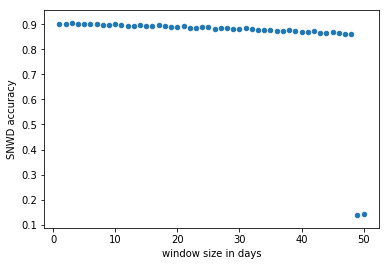

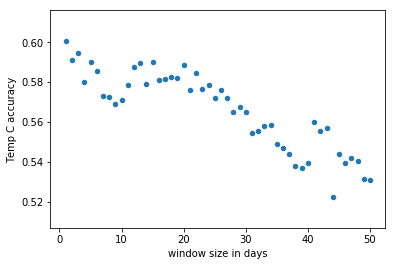

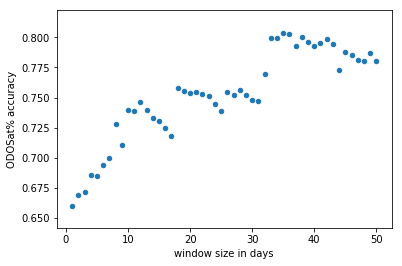

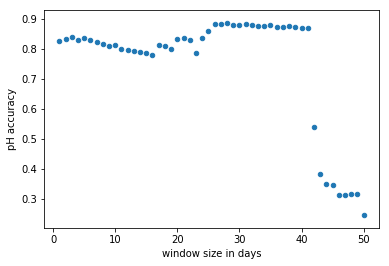

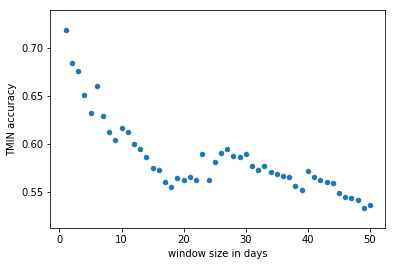

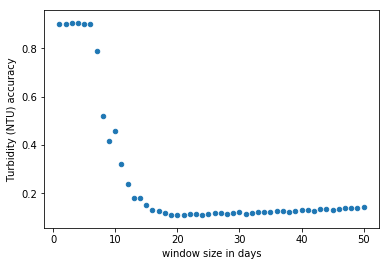

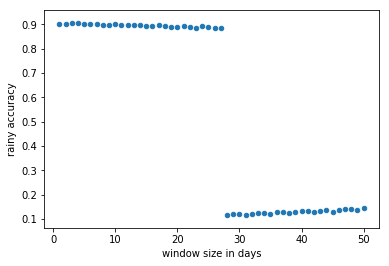

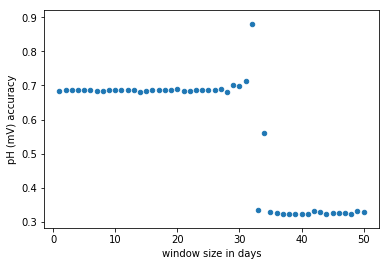

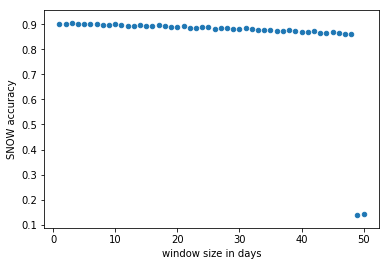

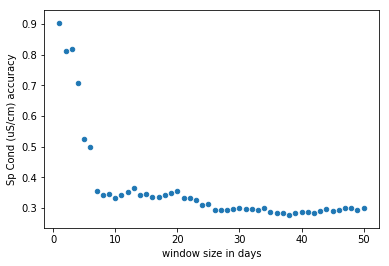

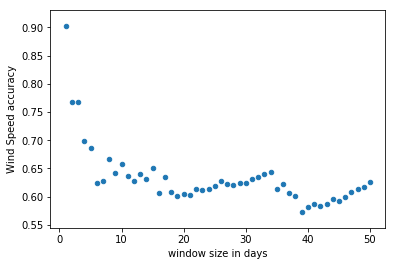

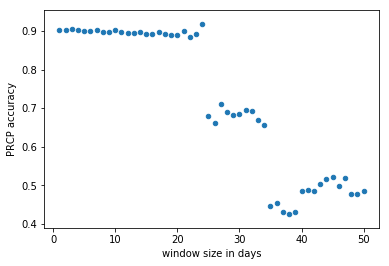

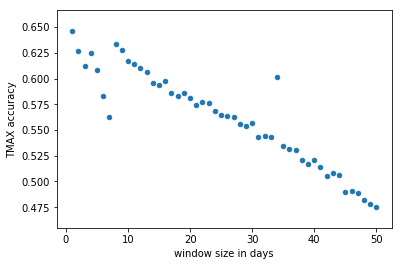

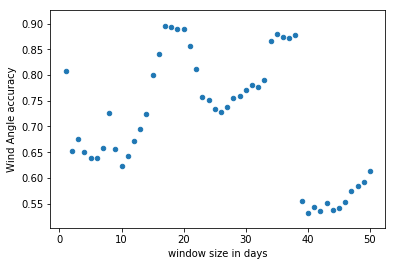

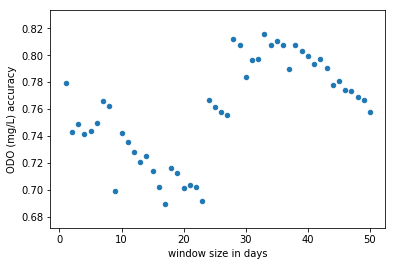

In [38]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Custom Window Size
Create a greedy model using the best custom window sizes found above.

In [39]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, x_win in best_x_windows.items():
    print(col, x_win)
    parameters[col] = {'x_win_size':x_win}

# Windowize
print("Windowizing 2017 data sets")
train = hf.windowize(train_dfs[0], 'datetime', 
                     target_column, custom_parameters=parameters)
for i in range(1, len(train_dfs)):
    train = train.append(hf.windowize(train_dfs[i], 'datetime', 
                         target_column, custom_parameters=parameters))
    print("Windowizing 2018 data sets")
test = hf.windowize(test_dfs[0], 'datetime', 
                    target_column, custom_parameters=parameters)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(test_dfs[i], 'datetime', 
                        target_column, custom_parameters=parameters))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()



SNWD 3 days 00:00:00
Temp C 1 days 00:00:00
ODOSat% 18 days 00:00:00
pH 28 days 00:00:00
TMIN 1 days 00:00:00
Turbidity (NTU) 3 days 00:00:00
rainy 3 days 00:00:00
pH (mV) 29 days 00:00:00
SNOW 3 days 00:00:00
Sp Cond (uS/cm) 1 days 00:00:00
Wind Speed 1 days 00:00:00
PRCP 24 days 00:00:00
TMAX 1 days 00:00:00
Wind Angle 17 days 00:00:00
ODO (mg/L) 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model with: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.8806201550387597
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[568   0]
 [ 77   0]]

Training model with: Temp C
Accuracy 0.4868217054263566
Recall: 0.8701298701298701
Precision 0.17268041237113402
Confusion Matrix:
 [[247 321]
 [ 10  67]]

Training model with: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6945736434108527
Recall: 0.7402597402597403
Precision 0.24358974358974358
Confusion Matrix:
 [[391 177]
 [ 20  57]]

Training model with: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.8806201550387597
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[568   0]
 [ 77   0]]

Training model with: TMIN
Accuracy 0.4945736434108527
Recall: 0.8571428571428571
Precision 0.1732283464566929
Confusion Matrix:
 [[253 315]
 [ 11  66]]

Training model with: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.28527131782945736
Recall: 0.8701298701298701
Precision 0.12934362934362933
Confusion Matrix:
 [[117 451]
 [ 10  67]]

Training model with: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.8806201550387597
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[568   0]
 [ 77   0]]

Training model with: pH (mV)
Accuracy 0.7007751937984497
Recall: 0.4155844155844156
Precision 0.17777777777777778
Confusion Matrix:
 [[420 148]
 [ 45  32]]

Training model with: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.8806201550387597
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[568   0]
 [ 77   0]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.3085271317829457
Recall: 0.8701298701298701
Precision 0.13320079522862824
Confusion Matrix:
 [[132 436]
 [ 10  67]]

Training model with: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7875968992248062
Recall: 0.23376623376623376
Precision 0.1875
Confusion Matrix:
 [[490  78]
 [ 59  18]]

Training model with: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6697674418604651
Recall: 0.7532467532467533
Precision 0.23015873015873015
Confusion Matrix:
 [[374 194]
 [ 19  58]]

Training model with: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.49147286821705427
Recall: 0.8051948051948052
Precision 0.16533333333333333
Confusion Matrix:
 [[255 313]
 [ 15  62]]

Training model with: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7968992248062016
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[514  54]
 [ 77   0]]

Training model with: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.8077519379844961
Recall: 0.5324675324675324
Precision 0.3178294573643411
Confusion Matrix:
 [[480  88]
 [ 36  41]]

SNWD metric value: 0.8806201550387597
pH metric value: 0.8806201550387597
rainy metric value: 0.8806201550387597
SNOW metric value: 0.8806201550387597
ODO (mg/L) metric value: 0.8077519379844961
Wind Angle metric value: 0.7968992248062016
Wind Speed metric value: 0.7875968992248062
pH (mV) metric value: 0.7007751937984497
ODOSat% metric value: 0.6945736434108527
PRCP metric value: 0.6697674418604651
TMIN metric value: 0.4945736434108527
TMAX metric value: 0.49147286821705427
Temp C metric value: 0.4868217054263566
Sp Cond (uS/cm) metric value: 0.3085271317829457
Turbidity (NTU) metric value: 0.28527131782945736


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8806201550387597
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[568   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'Wind Speed', 'pH (mV)', 'ODOSat%', 'PRCP', 'TMIN', 'TMAX', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'Wind Speed', 'pH (mV)', 'ODOSat%', 'PRCP', 'TMIN', 'TMAX', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8077519379844961
Test model recall: 0.5324675324675324
Test model precision: 0.3178294573643411

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8155038759689922
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7875968992248062
Test model recall: 0.23376623376623376
Test model precision: 0.1875

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7007751937984497
Test model recall: 0.4155844155844156
Test model precision: 0.17777777777777778

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6945736434108527
Test model recall: 0.7402597402597403
Test model precision: 0.24358974358974358

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6697674418604651
Test model recall: 0.7532467532467533
Test model precision: 0.23015873015873015

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4945736434108527
Test model recall: 0.8571428571428571
Test model precision: 0.1732283464566929

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.49147286821705427
Test model recall: 0.8051948051948052
Test model precision: 0.16533333333333333

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4868217054263566
Test model recall: 0.8701298701298701
Test model precision: 0.17268041237113402

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.30387596899224806
Test model recall: 0.8701298701298701
Test model precision: 0.1324110671936759

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.28527131782945736
Test model recall: 0.8701298701298701
Test model precision: 0.12934362934362933

Final greedy columns: []
Final greedy accuracy 0.8806201550387597
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[568   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8806201550387597
recall 0.0
precision 0.0



In [40]:
print("Cross validate:")
base_columns = ['TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)']

print("test vs train:")
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

Cross validate:
test vs train:


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7981981981981981
recall 0.6747967479674797
precision 0.8383838383838383



Performance of the model and the columns it selects seems to be largely dependent on the buey location.

## Greedy Window Size
Find a single optimal window size for all features

In [41]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data sets")
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data sets")
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Null model accuracy 0.9024081115335868
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[712   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'Sp Cond (uS/cm)', 'Wind Speed', 'PRCP', 'pH', 'Wind Angle', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'ODOSat%', 'TMAX', 'Temp C']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'Sp Cond (uS/cm)', 'Wind Speed', 'PRCP', 'pH', 'Wind Angle', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'ODOSat%', 'TMAX', 'Temp C']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9024081115335868
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8276299112801014
Test model recall: 0.19480519480519481
Test model precision: 0.16853932584269662

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7946768060836502
Test model recall: 0.07792207792207792
Test model precision: 0.061855670103092786

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7832699619771863
Test model recall: 0.5714285714285714
Test model precision: 0.24175824175824176

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7186311787072244
Test model recall: 0.6363636363636364
Test model precision: 0.20164609053497942

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6831432192648923
Test model recall: 0.4155844155844156
Test model precision: 0.1350210970464135

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6603295310519645
Test model recall: 0.7402597402597403
Test model precision: 0.18688524590163935

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6463878326996197
Test model recall: 0.7142857142857143
Test model precision: 0.1762820512820513

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6007604562737643
Test model recall: 0.8051948051948052
Test model precision: 0.1712707182320442

Final greedy columns: []
Final greedy accuracy 0.9024081115335868
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[712   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9024081115335868
recall 0.0
precision 0.0

Better Accuracy Found
current x window 2 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows.

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9016602809706258
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[706   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'ODOSat%', 'Wind Angle', 'TMAX', 'Temp C']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'ODOSat%', 'Wind Angle', 'TMAX', 'Temp C']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9016602809706258
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8339719029374202
Test model recall: 0.19480519480519481
Test model precision: 0.18072289156626506

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8135376756066411
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7675606641123882
Test model recall: 0.2727272727272727
Test model precision: 0.14285714285714285

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7432950191570882
Test model recall: 0.6363636363636364
Test model precision: 0.22072072072072071

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.685823754789272
Test model recall: 0.42857142857142855
Test model precision: 0.14042553191489363

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6845466155810983
Test model recall: 0.6883116883116883
Test model precision: 0.19202898550724637

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.669220945083014
Test model recall: 0.7922077922077922
Test model precision: 0.20065789473684212

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6526181353767561
Test model recall: 0.11688311688311688
Test model precision: 0.04225352112676056

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6270753512132823
Test model recall: 0.8441558441558441
Test model precision: 0.18840579710144928

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5913154533844189
Test model recall: 0.8441558441558441
Test model precision: 0.1742627345844504

Final greedy columns: []
Final greedy accuracy 0.9016602809706258
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[706   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9016602809706258
recall 0.0
precision 0.0

current x window 3 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target w

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9060489060489061
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[704   0]
 [ 73   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'Wind Angle', 'ODOSat%', 'TMAX', 'Temp C']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'Wind Angle', 'ODOSat%', 'TMAX', 'Temp C']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9060489060489061
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8391248391248392
Test model recall: 0.1780821917808219
Test model precision: 0.16666666666666666

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8172458172458172
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.767052767052767
Test model recall: 0.2054794520547945
Test model precision: 0.10869565217391304

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.749034749034749
Test model recall: 0.684931506849315
Test model precision: 0.22522522522522523

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.685971685971686
Test model recall: 0.4246575342465753
Test model precision: 0.13304721030042918

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6756756756756757
Test model recall: 0.6438356164383562
Test model precision: 0.17216117216117216

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6756756756756757
Test model recall: 0.0958904109589041
Test model precision: 0.03626943005181347

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6718146718146718
Test model recall: 0.726027397260274
Test model precision: 0.1840277777777778

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6126126126126126
Test model recall: 0.863013698630137
Test model precision: 0.17796610169491525

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5945945945945946
Test model recall: 0.8767123287671232
Test model precision: 0.17297297297297298

Final greedy columns: []
Final greedy accuracy 0.9060489060489061
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[704   0]
 [ 73   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9060489060489061
recall 0.0
precision 0.0

Better Accuracy Found
current x window 4 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9031007751937985
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[699   0]
 [ 75   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODOSat%', 'pH (mV)', 'TMIN', 'Wind Angle', 'TMAX', 'Temp C']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Wind Speed', 'ODOSat%', 'pH (mV)', 'TMIN', 'Wind Angle', 'TMAX', 'Temp C']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9031007751937985
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8307493540051679
Test model recall: 0.16
Test model precision: 0.15

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7416020671834626
Test model recall: 0.6266666666666667
Test model precision: 0.2146118721461187

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.710594315245478
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6976744186046512
Test model recall: 0.37333333333333335
Test model precision: 0.13023255813953488

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6873385012919897
Test model recall: 0.72
Test model precision: 0.19636363636363635

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.686046511627907
Test model recall: 0.4266666666666667
Test model precision: 0.13793103448275862

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6511627906976745
Test model recall: 0.64
Test model precision: 0.16494845360824742

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6498708010335917
Test model recall: 0.09333333333333334
Test model precision: 0.03333333333333333

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6253229974160207
Test model recall: 0.8666666666666667
Test model precision: 0.18840579710144928

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5801033591731266
Test model recall: 0.8666666666666667
Test model precision: 0.17105263157894737

Final greedy columns: []
Final greedy accuracy 0.9031007751937985
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[699   0]
 [ 75   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9031007751937985
recall 0.0
precision 0.0

current x window 5 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8997395833333334
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[691   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'ODOSat%', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8997395833333334
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8359375
Test model recall: 0.16883116883116883
Test model precision: 0.17333333333333334

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7434895833333334
Test model recall: 0.6363636363636364
Test model precision: 0.22477064220183487

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6861979166666666
Test model recall: 0.42857142857142855
Test model precision: 0.14347826086956522

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6861979166666666
Test model recall: 0.33766233766233766
Test model precision: 0.12037037037037036

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6848958333333334
Test model recall: 0.7272727272727273
Test model precision: 0.20216606498194944

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6380208333333334
Test model recall: 0.23376623376623376
Test model precision: 0.0759493670886076

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6328125
Test model recall: 0.6753246753246753
Test model precision: 0.16828478964401294

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6080729166666666
Test model recall: 0.8831168831168831
Test model precision: 0.18888888888888888

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.58984375
Test model recall: 0.8831168831168831
Test model precision: 0.18181818181818182

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5247395833333334
Test model recall: 0.5844155844155844
Test model precision: 0.11904761904761904

Final greedy columns: []
Final greedy accuracy 0.8997395833333334
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[691   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8997395833333334
recall 0.0
precision 0.0

current x window 6 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9002624671916011
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[686   0]
 [ 76   0]]
base_columns: []
sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'TMIN', 'Wind Angle', 'Wind Speed', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'Turbidity (NTU)', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'TMIN', 'Wind Angle', 'Wind Speed', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9002624671916011
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8307086614173228
Test model recall: 0.14473684210526316
Test model precision: 0.14666666666666667

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7493438320209974
Test model recall: 0.6842105263157895
Test model precision: 0.2374429223744292

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6942257217847769
Test model recall: 0.7105263157894737
Test model precision: 0.2037735849056604

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6876640419947506
Test model recall: 0.4342105263157895
Test model precision: 0.14473684210526316

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6601049868766404
Test model recall: 0.631578947368421
Test model precision: 0.17204301075268819

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6391076115485564
Test model recall: 0.09210526315789473
Test model precision: 0.03286384976525822

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6233595800524935
Test model recall: 0.32894736842105265
Test model precision: 0.09578544061302682

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5853018372703412
Test model recall: 0.8947368421052632
Test model precision: 0.18085106382978725

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5826771653543307
Test model recall: 0.8947368421052632
Test model precision: 0.17989417989417988

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5
Test model recall: 0.631578947368421
Test model precision: 0.11970074812967581

Final greedy columns: []
Final greedy accuracy 0.9002624671916011
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[686   0]
 [ 76   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9002624671916011
recall 0.0
precision 0.0

current x window 7 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combi

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9021164021164021
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[682   0]
 [ 74   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'Turbidity (NTU)', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'Wind Angle', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'Turbidity (NTU)', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'Wind Angle', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9021164021164021
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8240740740740741
Test model recall: 0.04054054054054054
Test model precision: 0.046153846153846156

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.791005291005291
Test model recall: 0.02702702702702703
Test model precision: 0.022727272727272728

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7658730158730159
Test model recall: 0.7162162162162162
Test model precision: 0.2535885167464115

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6997354497354498
Test model recall: 0.7162162162162162
Test model precision: 0.20463320463320464

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6825396825396826
Test model recall: 0.40540540540540543
Test model precision: 0.13274336283185842

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6574074074074074
Test model recall: 0.02702702702702703
Test model precision: 0.010582010582010581

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6296296296296297
Test model recall: 0.5945945945945946
Test model precision: 0.14965986394557823

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6283068783068783
Test model recall: 0.44594594594594594
Test model precision: 0.12087912087912088

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5727513227513228
Test model recall: 0.8783783783783784
Test model precision: 0.17150395778364116

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5621693121693122
Test model recall: 0.8783783783783784
Test model precision: 0.16795865633074936

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.35714285714285715
Test model recall: 0.9459459459459459
Test model precision: 0.12681159420289856

Final greedy columns: []
Final greedy accuracy 0.9021164021164021
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[682   0]
 [ 74   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9021164021164021
recall 0.0
precision 0.0

current x window 8 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.897742363877822
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[676   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.897742363877822
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8167330677290837
Test model recall: 0.05194805194805195
Test model precision: 0.057971014492753624

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7622841965471447
Test model recall: 0.6753246753246753
Test model precision: 0.2524271844660194

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7277556440903055
Test model recall: 0.7142857142857143
Test model precision: 0.23109243697478993

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7264276228419655
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6839309428950863
Test model recall: 0.4155844155844156
Test model precision: 0.14222222222222222

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6666666666666666
Test model recall: 0.7792207792207793
Test model precision: 0.20408163265306123

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6334661354581673
Test model recall: 0.8701298701298701
Test model precision: 0.2012012012012012

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6122177954847278
Test model recall: 0.6103896103896104
Test model precision: 0.15210355987055016

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5723771580345286
Test model recall: 0.8831168831168831
Test model precision: 0.1784776902887139

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5219123505976095
Test model recall: 0.16883116883116883
Test model precision: 0.042071197411003236

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.34130146082337315
Test model recall: 0.961038961038961
Test model precision: 0.13051146384479717

Final greedy columns: []
Final greedy accuracy 0.897742363877822
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[676   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.897742363877822
recall 0.0
precision 0.0

current x window 9 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target wi

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8969210174029452
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[670   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8969210174029452
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8969210174029452
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8969210174029452
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8969210174029452
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8099062918340026
Test model recall: 0.06493506493506493
Test model precision: 0.06666666666666667

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7108433734939759
Test model recall: 0.7662337662337663
Test model precision: 0.22957198443579765

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6987951807228916
Test model recall: 0.7012987012987013
Test model precision: 0.2109375

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6867469879518072
Test model recall: 0.42857142857142855
Test model precision: 0.14798206278026907

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6559571619812584
Test model recall: 0.03896103896103896
Test model precision: 0.016129032258064516

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6412315930388219
Test model recall: 0.8831168831168831
Test model precision: 0.20795107033639143

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6278447121820616
Test model recall: 0.8961038961038961
Test model precision: 0.20353982300884957

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6037483266398929
Test model recall: 0.6623376623376623
Test model precision: 0.1588785046728972

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5689424364123159
Test model recall: 0.922077922077922
Test model precision: 0.1834625322997416

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.41767068273092367
Test model recall: 0.5844155844155844
Test model precision: 0.10044642857142858

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3467202141900937
Test model recall: 0.974025974025974
Test model precision: 0.13368983957219252

Final greedy columns: []
Final greedy accuracy 0.8969210174029452
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[670   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8969210174029452
recall 0.0
precision 0.0

current x window 10 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target 

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.9014844804318488
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[668   0]
 [ 73   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODO (mg/L)', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'TMIN', 'TMAX', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9014844804318488
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9014844804318488
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9014844804318488
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9014844804318488
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8137651821862348
Test model recall: 0.0821917808219178
Test model precision: 0.07792207792207792

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7422402159244265
Test model recall: 0.6986301369863014
Test model precision: 0.2318181818181818

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7395411605937922
Test model recall: 0.7397260273972602
Test model precision: 0.23684210526315788

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6869095816464238
Test model recall: 0.4246575342465753
Test model precision: 0.14027149321266968

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6572199730094467
Test model recall: 0.9041095890410958
Test model precision: 0.2108626198083067

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6234817813765182
Test model recall: 0.0684931506849315
Test model precision: 0.023148148148148147

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6167341430499326
Test model recall: 0.3424657534246575
Test model precision: 0.09578544061302682

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6167341430499326
Test model recall: 0.9178082191780822
Test model precision: 0.19420289855072465

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5708502024291497
Test model recall: 0.9315068493150684
Test model precision: 0.1784776902887139

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4574898785425101
Test model recall: 0.8767123287671232
Test model precision: 0.1400437636761488

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3319838056680162
Test model recall: 0.9726027397260274
Test model precision: 0.12588652482269502

Final greedy columns: []
Final greedy accuracy 0.9014844804318488
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[668   0]
 [ 73   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.9014844804318488
recall 0.0
precision 0.0

current x window 11 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8983739837398373
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[663   0]
 [ 75   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8983739837398373
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.7994579945799458
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7384823848238482
Test model recall: 0.7333333333333333
Test model precision: 0.2412280701754386

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7357723577235772
Test model recall: 0.68
Test model precision: 0.22972972972972974

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6869918699186992
Test model recall: 0.4266666666666667
Test model precision: 0.14545454545454545

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6422764227642277
Test model recall: 0.04
Test model precision: 0.015384615384615385

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6368563685636857
Test model recall: 0.9066666666666666
Test model precision: 0.2066869300911854

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6138211382113821
Test model recall: 0.92
Test model precision: 0.19827586206896552

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6124661246612466
Test model recall: 0.41333333333333333
Test model precision: 0.11355311355311355

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5785907859078591
Test model recall: 0.92
Test model precision: 0.18449197860962566

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3428184281842818
Test model recall: 0.9733333333333334
Test model precision: 0.13129496402877697

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.31978319783197834
Test model recall: 0.96
Test model precision: 0.12609457092819615

Final greedy columns: []
Final greedy accuracy 0.8983739837398373
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[663   0]
 [ 75   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8983739837398373
recall 0.0
precision 0.0

current x window 12 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
C

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.894808743169399
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[655   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.894808743169399
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.796448087431694
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7459016393442623
Test model recall: 0.7272727272727273
Test model precision: 0.25339366515837103

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7281420765027322
Test model recall: 0.5454545454545454
Test model precision: 0.20388349514563106

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6857923497267759
Test model recall: 0.42857142857142855
Test model precision: 0.1506849315068493

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6721311475409836
Test model recall: 0.05194805194805195
Test model precision: 0.023391812865497075

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6284153005464481
Test model recall: 0.935064935064935
Test model precision: 0.21238938053097345

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.610655737704918
Test model recall: 0.948051948051948
Test model precision: 0.2062146892655367

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5997267759562842
Test model recall: 0.42857142857142855
Test model precision: 0.11702127659574468

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.587431693989071
Test model recall: 0.935064935064935
Test model precision: 0.1951219512195122

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.35382513661202186
Test model recall: 0.974025974025974
Test model precision: 0.13736263736263737

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.23770491803278687
Test model recall: 0.974025974025974
Test model precision: 0.11885895404120443

Final greedy columns: []
Final greedy accuracy 0.894808743169399
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[655   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.894808743169399
recall 0.0
precision 0.0

current x window 13 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target w

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8953168044077136
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[650   0]
 [ 76   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8953168044077136
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.7933884297520661
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7396694214876033
Test model recall: 0.7236842105263158
Test model precision: 0.24663677130044842

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7203856749311295
Test model recall: 0.5657894736842105
Test model precision: 0.20187793427230047

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6955922865013774
Test model recall: 0.05263157894736842
Test model precision: 0.026143790849673203

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6873278236914601
Test model recall: 0.4342105263157895
Test model precision: 0.15207373271889402

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.640495867768595
Test model recall: 0.9210526315789473
Test model precision: 0.2153846153846154

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6060606060606061
Test model recall: 0.9473684210526315
Test model precision: 0.2033898305084746

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5950413223140496
Test model recall: 0.42105263157894735
Test model precision: 0.11347517730496454

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5895316804407713
Test model recall: 0.9342105263157895
Test model precision: 0.19505494505494506

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3650137741046832
Test model recall: 0.9736842105263158
Test model precision: 0.13883677298311445

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.18181818181818182
Test model recall: 0.9868421052631579
Test model precision: 0.1122754491017964

Final greedy columns: []
Final greedy accuracy 0.8953168044077136
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[650   0]
 [ 76   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8953168044077136
recall 0.0
precision 0.0

current x window 14 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8972222222222223
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[646   0]
 [ 74   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'pH (mV)', 'Wind Speed', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8972222222222223
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.7944444444444444
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7333333333333333
Test model recall: 0.7297297297297297
Test model precision: 0.23893805309734514

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.725
Test model recall: 0.5945945945945946
Test model precision: 0.20754716981132076

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7236111111111111
Test model recall: 0.02702702702702703
Test model precision: 0.015503875968992248

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6819444444444445
Test model recall: 0.40540540540540543
Test model precision: 0.13953488372093023

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6416666666666667
Test model recall: 0.9054054054054054
Test model precision: 0.21069182389937108

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5958333333333333
Test model recall: 0.9459459459459459
Test model precision: 0.19607843137254902

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5861111111111111
Test model recall: 0.43243243243243246
Test model precision: 0.1111111111111111

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5791666666666667
Test model recall: 0.9324324324324325
Test model precision: 0.1880108991825613

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3416666666666667
Test model recall: 0.972972972972973
Test model precision: 0.1323529411764706

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.18194444444444444
Test model recall: 1.0
Test model precision: 0.11161387631975868

Final greedy columns: []
Final greedy accuracy 0.8972222222222223
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[646   0]
 [ 74   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8972222222222223
recall 0.0
precision 0.0

current x window 15 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8926080892608089
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[640   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8926080892608089
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8926080892608089
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8926080892608089
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8926080892608089
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']
Test model accuracy: 0.800557880055788
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7866108786610879
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7308228730822873
Test model recall: 0.7402597402597403
Test model precision: 0.24782608695652175

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7140864714086471
Test model recall: 0.5844155844155844
Test model precision: 0.20642201834862386

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6834030683403068
Test model recall: 0.4155844155844156
Test model precision: 0.14953271028037382

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6513249651324965
Test model recall: 0.987012987012987
Test model precision: 0.23384615384615384

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5941422594142259
Test model recall: 0.948051948051948
Test model precision: 0.20277777777777778

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5899581589958159
Test model recall: 0.948051948051948
Test model precision: 0.20110192837465565

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5746164574616457
Test model recall: 0.42857142857142855
Test model precision: 0.11224489795918367

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3458856345885635
Test model recall: 0.974025974025974
Test model precision: 0.13837638376383765

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.15202231520223153
Test model recall: 1.0
Test model precision: 0.11240875912408758

Final greedy columns: []
Final greedy accuracy 0.8926080892608089
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[640   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8926080892608089
recall 0.0
precision 0.0

current x window 16 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8917018284106891
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[634   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8917018284106891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8917018284106891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8917018284106891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8917018284106891
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']
Test model accuracy: 0.8410689170182841
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7805907172995781
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7243319268635724
Test model recall: 0.7402597402597403
Test model precision: 0.2446351931330472

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7018284106891702
Test model recall: 0.5714285714285714
Test model precision: 0.19730941704035873

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6863572433192686
Test model recall: 0.42857142857142855
Test model precision: 0.15566037735849056

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6061884669479606
Test model recall: 0.974025974025974
Test model precision: 0.21246458923512748

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5977496483825597
Test model recall: 0.961038961038961
Test model precision: 0.20728291316526612

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5808720112517581
Test model recall: 0.961038961038961
Test model precision: 0.2005420054200542

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5724331926863573
Test model recall: 0.45454545454545453
Test model precision: 0.11784511784511785

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3361462728551336
Test model recall: 0.987012987012987
Test model precision: 0.13893967093235832

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.1308016877637131
Test model recall: 1.0
Test model precision: 0.11079136690647481

Final greedy columns: []
Final greedy accuracy 0.8917018284106891
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[634   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8917018284106891
recall 0.0
precision 0.0

current x window 17 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Com

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8964539007092198
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[632   0]
 [ 73   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8964539007092198
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8141843971631205
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7177304964539007
Test model recall: 0.7123287671232876
Test model precision: 0.22608695652173913

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6893617021276596
Test model recall: 0.5753424657534246
Test model precision: 0.1826086956521739

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6865248226950355
Test model recall: 0.4246575342465753
Test model precision: 0.14761904761904762

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6354609929078014
Test model recall: 0.958904109589041
Test model precision: 0.21604938271604937

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5858156028368794
Test model recall: 0.9452054794520548
Test model precision: 0.19327731092436976

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5815602836879432
Test model recall: 0.9452054794520548
Test model precision: 0.19166666666666668

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5602836879432624
Test model recall: 0.4520547945205479
Test model precision: 0.10891089108910891

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3347517730496454
Test model recall: 0.9726027397260274
Test model precision: 0.13197026022304834

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.1276595744680851
Test model recall: 1.0
Test model precision: 0.10610465116279069

Final greedy columns: []
Final greedy accuracy 0.8964539007092198
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[632   0]
 [ 73   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8964539007092198
recall 0.0
precision 0.0

current x window 18 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Com

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8931623931623932
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[627   0]
 [ 75   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8931623931623932
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8091168091168092
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7578347578347578
Test model recall: 0.7333333333333333
Test model precision: 0.2682926829268293

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7165242165242165
Test model recall: 0.5733333333333334
Test model precision: 0.20476190476190476

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6866096866096866
Test model recall: 0.4266666666666667
Test model precision: 0.15311004784688995

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6082621082621082
Test model recall: 0.9866666666666667
Test model precision: 0.21264367816091953

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5826210826210826
Test model recall: 0.9466666666666667
Test model precision: 0.19722222222222222

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5826210826210826
Test model recall: 0.9466666666666667
Test model precision: 0.19722222222222222

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5555555555555556
Test model recall: 0.48
Test model precision: 0.11650485436893204

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3418803418803419
Test model recall: 0.9733333333333334
Test model precision: 0.13696060037523453

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11965811965811966
Test model recall: 1.0
Test model precision: 0.10822510822510822

Final greedy columns: []
Final greedy accuracy 0.8931623931623932
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[627   0]
 [ 75   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8931623931623932
recall 0.0
precision 0.0

current x window 19 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.889367816091954
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[619   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'TMAX', 'Temp C', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.889367816091954
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8017241379310345
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7557471264367817
Test model recall: 0.7142857142857143
Test model precision: 0.270935960591133

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7126436781609196
Test model recall: 0.5714285714285714
Test model precision: 0.20853080568720378

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6867816091954023
Test model recall: 0.42857142857142855
Test model precision: 0.15942028985507245

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6005747126436781
Test model recall: 0.935064935064935
Test model precision: 0.20869565217391303

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5862068965517241
Test model recall: 0.948051948051948
Test model precision: 0.20448179271708683

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5818965517241379
Test model recall: 0.948051948051948
Test model precision: 0.20277777777777778

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5646551724137931
Test model recall: 0.5584415584415584
Test model precision: 0.13782051282051283

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.34913793103448276
Test model recall: 0.974025974025974
Test model precision: 0.14258555133079848

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11063218390804598
Test model recall: 1.0
Test model precision: 0.11063218390804598

Final greedy columns: []
Final greedy accuracy 0.889367816091954
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[619   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.889367816091954
recall 0.0
precision 0.0

current x window 20 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8898550724637682
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[614   0]
 [ 76   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8898550724637682
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8347826086956521
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7536231884057971
Test model recall: 0.7105263157894737
Test model precision: 0.26732673267326734

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7014492753623188
Test model recall: 0.5657894736842105
Test model precision: 0.19907407407407407

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6884057971014492
Test model recall: 0.4342105263157895
Test model precision: 0.16097560975609757

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6043478260869565
Test model recall: 0.9342105263157895
Test model precision: 0.20943952802359883

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5884057971014492
Test model recall: 0.9342105263157895
Test model precision: 0.20285714285714285

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5811594202898551
Test model recall: 0.9473684210526315
Test model precision: 0.20168067226890757

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5623188405797102
Test model recall: 0.6052631578947368
Test model precision: 0.14465408805031446

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.35507246376811596
Test model recall: 0.9736842105263158
Test model precision: 0.14313346228239845

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11159420289855072
Test model recall: 1.0
Test model precision: 0.11030478955007257

Final greedy columns: []
Final greedy accuracy 0.8898550724637682
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[614   0]
 [ 76   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8898550724637682
recall 0.0
precision 0.0

current x window 21 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8918128654970761
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[610   0]
 [ 74   0]]
base_columns: []
sorted_columns: ['PRCP', 'SNWD', 'rainy', 'SNOW', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['PRCP', 'SNWD', 'rainy', 'SNOW', 'Wind Angle', 'pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['PRCP']
Test model accuracy: 0.9005847953216374
Test model recall: 0.6486486486486487
Test model precision: 0.5333333333333333

Updating greedy model

Training model with: ['PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9005847953216374
Test model recall: 0.6486486486486487
Test model precision: 0.5333333333333333

Training model with: ['PRCP', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.564327485380117
Test model recall: 0.1891891891891892
Test model precision: 0.05555555555555555

Training model with: ['PRCP', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9005847953216374
Test model recall: 0.6486486486486487
Test model precision: 0.5333333333333333

Training model with: ['PRCP', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8391812865497076
Test model recall: 0.6081081081081081
Test model precision: 0.35714285714285715

Training model with: ['PRCP', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7923976608187134
Test model recall: 0.04054054054054054
Test model precision: 0.04054054054054054

Training model with: ['PRCP', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7353801169590644
Test model recall: 0.7432432432432432
Test model precision: 0.2534562211981567

Training model with: ['PRCP', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7412280701754386
Test model recall: 0.6351351351351351
Test model precision: 0.23857868020304568

Training model with: ['PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7017543859649122
Test model recall: 0.40540540540540543
Test model precision: 0.15789473684210525

Training model with: ['PRCP', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.597953216374269
Test model recall: 0.9324324324324325
Test model precision: 0.20353982300884957

Training model with: ['PRCP', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.533625730994152
Test model recall: 0.9054054054054054
Test model precision: 0.17678100263852242

Training model with: ['PRCP', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4868421052631579
Test model recall: 0.9459459459459459
Test model precision: 0.16786570743405277

Training model with: ['PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5921052631578947
Test model recall: 0.9459459459459459
Test model precision: 0.2028985507246377

Training model with: ['PRCP', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.41812865497076024
Test model recall: 0.9459459459459459
Test model precision: 0.15086206896551724

Training model with: ['PRCP', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3757309941520468
Test model recall: 0.9459459459459459
Test model precision: 0.14198782961460446

Final greedy columns: ['PRCP']
Final greedy accuracy 0.9005847953216374
Final greedy recall: 0.6486486486486487
Final greedy precision: 0.5333333333333333
Final greedy confusion matrix:
 [[568  42]
 [ 26  48]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.5780445969125214
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[337   0]
 [246   0]]
accuracy 0.9005847953216374
recall 0.6486486486486487
precision 0.5333333333333333

current x window 22 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8869309838472834
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[604   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'Wind Angle', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'PRCP', 'pH', 'Wind Angle', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8869309838472834
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']
Test model accuracy: 0.8839941262848752
Test model recall: 0.5324675324675324
Test model precision: 0.4880952380952381

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8296622613803231
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8120411160058737
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7533039647577092
Test model recall: 0.7142857142857143
Test model precision: 0.2736318407960199

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7019089574155654
Test model recall: 0.5844155844155844
Test model precision: 0.20833333333333334

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.684287812041116
Test model recall: 0.4155844155844156
Test model precision: 0.15841584158415842

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6138032305433186
Test model recall: 0.935064935064935
Test model precision: 0.21818181818181817

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5844346549192364
Test model recall: 0.935064935064935
Test model precision: 0.2057142857142857

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5770925110132159
Test model recall: 0.948051948051948
Test model precision: 0.20448179271708683

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5624082232011748
Test model recall: 0.5324675324675324
Test model precision: 0.1353135313531353

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3333333333333333
Test model recall: 0.974025974025974
Test model precision: 0.14231499051233396

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.1130690161527166
Test model recall: 1.0
Test model precision: 0.1130690161527166

Final greedy columns: []
Final greedy accuracy 0.8869309838472834
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[604   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8869309838472834
recall 0.0
precision 0.0

current x window 23 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8859259259259259
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[598   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'pH', 'Wind Angle', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'pH', 'Wind Angle', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8859259259259259
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8266666666666667
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7570370370370371
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7511111111111111
Test model recall: 0.7142857142857143
Test model precision: 0.2736318407960199

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6933333333333334
Test model recall: 0.5714285714285714
Test model precision: 0.2018348623853211

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6874074074074074
Test model recall: 0.42857142857142855
Test model precision: 0.165

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6607407407407407
Test model recall: 0.45454545454545453
Test model precision: 0.15765765765765766

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6118518518518519
Test model recall: 0.961038961038961
Test model precision: 0.2222222222222222

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5896296296296296
Test model recall: 0.922077922077922
Test model precision: 0.20760233918128654

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5762962962962963
Test model recall: 0.961038961038961
Test model precision: 0.20728291316526612

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5762962962962963
Test model recall: 0.961038961038961
Test model precision: 0.20728291316526612

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.32592592592592595
Test model recall: 0.987012987012987
Test model precision: 0.14339622641509434

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11407407407407408
Test model recall: 1.0
Test model precision: 0.11407407407407408

Final greedy columns: []
Final greedy accuracy 0.8859259259259259
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[598   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8859259259259259
recall 0.0
precision 0.0

current x window 24 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.890881913303438
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[596   0]
 [ 73   0]]
base_columns: []
sorted_columns: ['PRCP', 'SNWD', 'rainy', 'SNOW', 'pH', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['PRCP', 'SNWD', 'rainy', 'SNOW', 'pH', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['PRCP']
Test model accuracy: 0.9177877428998505
Test model recall: 0.3698630136986301
Test model precision: 0.75

Updating greedy model

Training model with: ['PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9177877428998505
Test model recall: 0.3698630136986301
Test model precision: 0.75

Training model with: ['PRCP', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.600896860986547
Test model recall: 0.4794520547945205
Test model precision: 0.13257575757575757

Training model with: ['PRCP', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.9177877428998505
Test model recall: 0.3698630136986301
Test model precision: 0.75

Training model with: ['PRCP', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7847533632286996
Test model recall: 0.0136986301369863
Test model precision: 0.0136986301369863

Training model with: ['PRCP', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7428998505231689
Test model recall: 0.6164383561643836
Test model precision: 0.23809523809523808

Training model with: ['PRCP', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7787742899850523
Test model recall: 0.5753424657534246
Test model precision: 0.2641509433962264

Training model with: ['PRCP', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7279521674140508
Test model recall: 0.7123287671232876
Test model precision: 0.24413145539906103

Training model with: ['PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.70254110612855
Test model recall: 0.4246575342465753
Test model precision: 0.16489361702127658

Training model with: ['PRCP', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5994020926756353
Test model recall: 0.9452054794520548
Test model precision: 0.2072072072072072

Training model with: ['PRCP', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5127055306427504
Test model recall: 0.9315068493150684
Test model precision: 0.17480719794344474

Training model with: ['PRCP', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.47384155455904337
Test model recall: 0.9452054794520548
Test model precision: 0.16546762589928057

Training model with: ['PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5814648729446936
Test model recall: 0.9452054794520548
Test model precision: 0.2

Training model with: ['PRCP', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.40956651718983555
Test model recall: 0.9452054794520548
Test model precision: 0.15

Training model with: ['PRCP', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.2944693572496263
Test model recall: 0.9452054794520548
Test model precision: 0.12849162011173185

Final greedy columns: ['PRCP']
Final greedy accuracy 0.9177877428998505
Final greedy recall: 0.3698630136986301
Final greedy precision: 0.75
Final greedy confusion matrix:
 [[587   9]
 [ 46  27]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.5699300699300699
Test model recall: 0.0
Test model precision: 0.0
Final greedy confusion matrix:
 [[326   0]
 [246   0]]
accuracy 0.9177877428998505
recall 0.3698630136986301
precision 0.75

Better Accuracy Found
current x window 25 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8873873873873874
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[591   0]
 [ 75   0]]
base_columns: []
sorted_columns: ['SNWD', 'rainy', 'SNOW', 'pH', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'rainy', 'SNOW', 'pH', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8873873873873874
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']
Test model accuracy: 0.8618618618618619
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7612612612612613
Test model recall: 0.5466666666666666
Test model precision: 0.2469879518072289

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7387387387387387
Test model recall: 0.64
Test model precision: 0.24615384615384617

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7342342342342343
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6861861861861862
Test model recall: 0.4266666666666667
Test model precision: 0.16161616161616163

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6786786786786787
Test model recall: 0.37333333333333335
Test model precision: 0.14358974358974358

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6186186186186187
Test model recall: 0.9466666666666667
Test model precision: 0.22118380062305296

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.581081081081081
Test model recall: 0.8
Test model precision: 0.18518518518518517

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5735735735735735
Test model recall: 0.92
Test model precision: 0.1988472622478386

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5645645645645646
Test model recall: 0.9466666666666667
Test model precision: 0.19887955182072828

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3123123123123123
Test model recall: 0.9733333333333334
Test model precision: 0.13799621928166353

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11261261261261261
Test model recall: 1.0
Test model precision: 0.11261261261261261

Final greedy columns: []
Final greedy accuracy 0.8873873873873874
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[591   0]
 [ 75   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8873873873873874
recall 0.0
precision 0.0

current x window 26 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8833333333333333
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[583   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8833333333333333
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7575757575757576
Test model recall: 0.5324675324675324
Test model precision: 0.24848484848484848

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7545454545454545
Test model recall: 0.5454545454545454
Test model precision: 0.2485207100591716

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7287878787878788
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6863636363636364
Test model recall: 0.42857142857142855
Test model precision: 0.1683673469387755

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6621212121212121
Test model recall: 0.7272727272727273
Test model precision: 0.21705426356589147

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6272727272727273
Test model recall: 0.948051948051948
Test model precision: 0.23174603174603176

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5909090909090909
Test model recall: 0.9090909090909091
Test model precision: 0.21021021021021022

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5757575757575758
Test model recall: 0.935064935064935
Test model precision: 0.207492795389049

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5636363636363636
Test model recall: 0.948051948051948
Test model precision: 0.20448179271708683

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.2924242424242424
Test model recall: 0.974025974025974
Test model precision: 0.1388888888888889

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11666666666666667
Test model recall: 1.0
Test model precision: 0.11666666666666667

Final greedy columns: []
Final greedy accuracy 0.8833333333333333
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[583   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8833333333333333
recall 0.0
precision 0.0

current x window 27 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8837920489296636
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[578   0]
 [ 76   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'PRCP', 'pH (mV)', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['SNWD', 'pH', 'rainy', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'PRCP', 'pH (mV)', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8837920489296636
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7553516819571865
Test model recall: 0.5394736842105263
Test model precision: 0.2469879518072289

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7522935779816514
Test model recall: 0.5394736842105263
Test model precision: 0.24404761904761904

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7370030581039755
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.709480122324159
Test model recall: 0.75
Test model precision: 0.25

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6880733944954128
Test model recall: 0.4342105263157895
Test model precision: 0.17010309278350516

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6223241590214067
Test model recall: 0.9473684210526315
Test model precision: 0.22857142857142856

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5948012232415902
Test model recall: 0.9473684210526315
Test model precision: 0.21621621621621623

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.573394495412844
Test model recall: 0.9473684210526315
Test model precision: 0.207492795389049

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5626911314984709
Test model recall: 0.9473684210526315
Test model precision: 0.2033898305084746

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.29510703363914376
Test model recall: 0.9736842105263158
Test model precision: 0.13883677298311445

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.1162079510703364
Test model recall: 1.0
Test model precision: 0.1162079510703364

Final greedy columns: []
Final greedy accuracy 0.8837920489296636
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[578   0]
 [ 76   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8837920489296636
recall 0.0
precision 0.0

current x window 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8858024691358025
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[574   0]
 [ 74   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'PRCP', 'pH (mV)', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'ODOSat%', 'Wind Angle', 'PRCP', 'pH (mV)', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8858024691358025
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8117283950617284
Test model recall: 0.5405405405405406
Test model precision: 0.3125

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7561728395061729
Test model recall: 0.5675675675675675
Test model precision: 0.25

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7561728395061729
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6898148148148148
Test model recall: 0.7432432432432432
Test model precision: 0.2320675105485232

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6820987654320988
Test model recall: 0.40540540540540543
Test model precision: 0.15625

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6203703703703703
Test model recall: 0.9459459459459459
Test model precision: 0.22435897435897437

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5879629629629629
Test model recall: 0.9459459459459459
Test model precision: 0.21021021021021022

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5632716049382716
Test model recall: 0.9459459459459459
Test model precision: 0.20057306590257878

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5555555555555556
Test model recall: 0.9459459459459459
Test model precision: 0.1977401129943503

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.2932098765432099
Test model recall: 0.972972972972973
Test model precision: 0.13636363636363635

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11419753086419752
Test model recall: 1.0
Test model precision: 0.11419753086419752

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11419753086419752
Test model recall: 1.0
Test model precision: 0.11419753086419752

Final greedy columns: []
Final greedy accuracy 0.8858024691358025
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[574   0]
 [ 74   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8858024691358025
recall 0.0
precision 0.0

current x window 29 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8806201550387597
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[568   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8806201550387597
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8077519379844961
Test model recall: 0.5324675324675324
Test model precision: 0.3178294573643411

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7596899224806202
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.751937984496124
Test model recall: 0.5584415584415584
Test model precision: 0.25443786982248523

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7007751937984497
Test model recall: 0.4155844155844156
Test model precision: 0.17777777777777778

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6821705426356589
Test model recall: 0.7662337662337663
Test model precision: 0.23983739837398374

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6232558139534884
Test model recall: 0.948051948051948
Test model precision: 0.23397435897435898

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.586046511627907
Test model recall: 0.948051948051948
Test model precision: 0.21726190476190477

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5674418604651162
Test model recall: 0.948051948051948
Test model precision: 0.20977011494252873

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5534883720930233
Test model recall: 0.948051948051948
Test model precision: 0.20448179271708683

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.2961240310077519
Test model recall: 0.974025974025974
Test model precision: 0.14231499051233396

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11937984496124031
Test model recall: 1.0
Test model precision: 0.11937984496124031

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.11937984496124031
Test model recall: 1.0
Test model precision: 0.11937984496124031

Final greedy columns: []
Final greedy accuracy 0.8806201550387597
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[568   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8806201550387597
recall 0.0
precision 0.0

current x window 30 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Null model accuracy 0.8794992175273866
Null model  recall: 0.0
Null model  precision: 0.0
Null model  confusion matrix:
 [[562   0]
 [ 77   0]]
base_columns: []
sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
adjusted sorted_columns: ['SNWD', 'pH', 'SNOW', 'ODO (mg/L)', 'Wind Angle', 'ODOSat%', 'pH (mV)', 'PRCP', 'Wind Speed', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'rainy']
Training model with: ['SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8794992175273866
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODO (mg/L)']
Test model accuracy: 0.784037558685446
Test model recall: 0.5194805194805194
Test model precision: 0.28368794326241137

Training model with: ['Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7715179968701096
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7480438184663537
Test model recall: 0.5454545454545454
Test model precision: 0.25

Training model with: ['pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6995305164319249
Test model recall: 0.42857142857142855
Test model precision: 0.18232044198895028

Training model with: ['PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6854460093896714
Test model recall: 0.7532467532467533
Test model precision: 0.24166666666666667

Training model with: ['Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6244131455399061
Test model recall: 0.987012987012987
Test model precision: 0.24126984126984127

Training model with: ['TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5899843505477308
Test model recall: 0.961038961038961
Test model precision: 0.2222222222222222

Training model with: ['Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.564945226917058
Test model recall: 0.961038961038961
Test model precision: 0.21203438395415472

Training model with: ['TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5571205007824727
Test model recall: 0.961038961038961
Test model precision: 0.20903954802259886

Training model with: ['Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.3004694835680751
Test model recall: 0.987012987012987
Test model precision: 0.14559386973180077

Training model with: ['Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.12050078247261346
Test model recall: 1.0
Test model precision: 0.12050078247261346

Training model with: ['rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.12050078247261346
Test model recall: 1.0
Test model precision: 0.12050078247261346

Final greedy columns: []
Final greedy accuracy 0.8794992175273866
Final greedy recall: 0.0
Final greedy precision: 0.0
Final greedy confusion matrix:
 [[562   0]
 [ 77   0]]
No greedy columns selected, skipping cross validation.
accuracy 0.8794992175273866
recall 0.0
precision 0.0



In [42]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

best accuracy 0.9177877428998505
best recall 0.3698630136986301
best precision 0.75
best x window 24 days 00:00:00


In [43]:
# Cross validate
base_columns = ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
# Windowize
print("current x window", best_x_window)
print("Windowizing 2017 data sets")
train = hf.windowize(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=best_x_window)
train = train.append(hf.windowize(
    train_dfs[1], 'datetime', target_column, 
    x_win_size=best_x_window))
print("Windowizing 2018 data sets")
test = hf.windowize(
    test_dfs[0], 'datetime', target_column,
    x_win_size=best_x_window)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(
        test_dfs[i], 'datetime', target_column,
        x_win_size=best_x_window))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom' )
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)

current x window 24 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5716783216783217
recall 0.0040650406504065045
precision 1.0


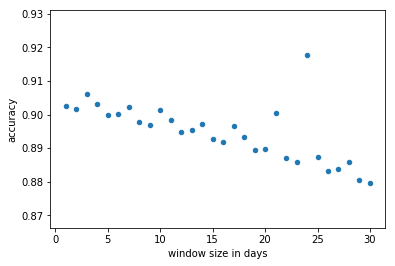

In [44]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")